In [1]:
from __future__ import print_function
import matplotlib.pyplot as plt
import numpy as np
import sys



import sklearn.metrics as metrics

import argparse
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import warnings
import statsmodels.api as sm
from matplotlib import cm

warnings.filterwarnings(action='ignore')
import dataframe_image as dfi
from sklearn.linear_model import LinearRegression
import os
from scipy import stats
from scipy.spatial import distance

In [18]:
folder_dir = '../dataset/3.preprocessed/'

list_data = os.listdir(folder_dir)
print(list_data)

['.ipynb_checkpoints', 'generated_1', 'generated_2', 'generated_3', 'preprocessing.ipynb', 'real_1_DR', 'real_2_TS', 'real_3_HT', 'real_4_MS']


# Calculate the stability

generated_1
generated_2
generated_3
real_1_DR
real_2_TS
real_3_HT
real_4_MS


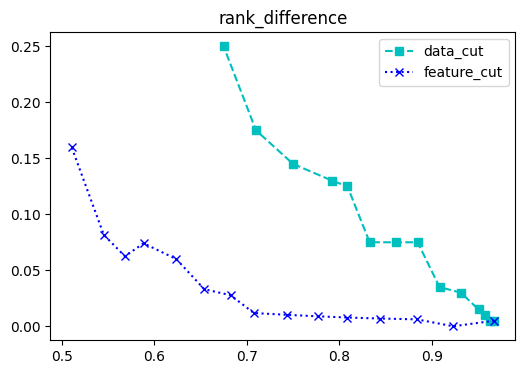

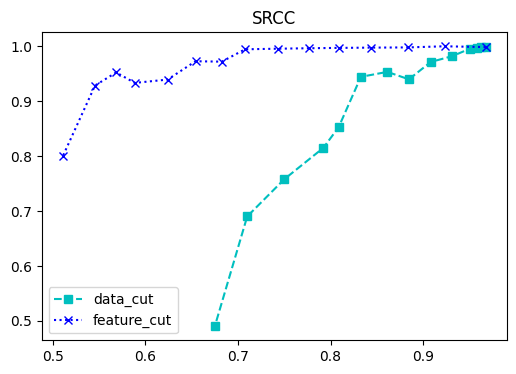

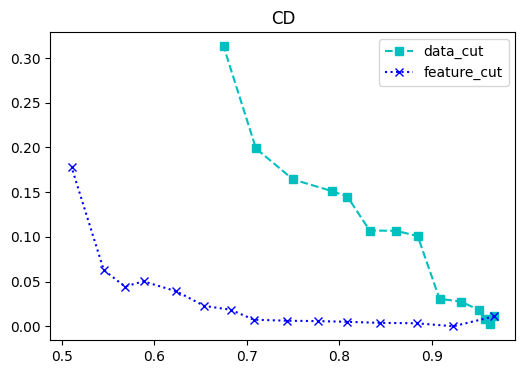

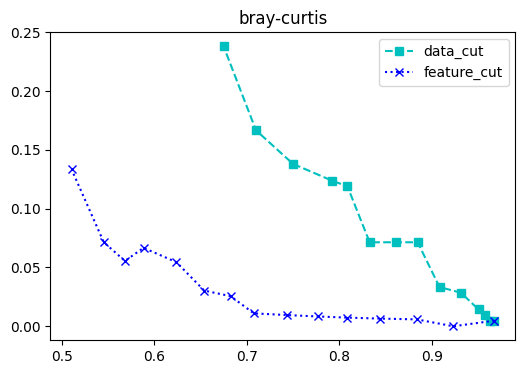

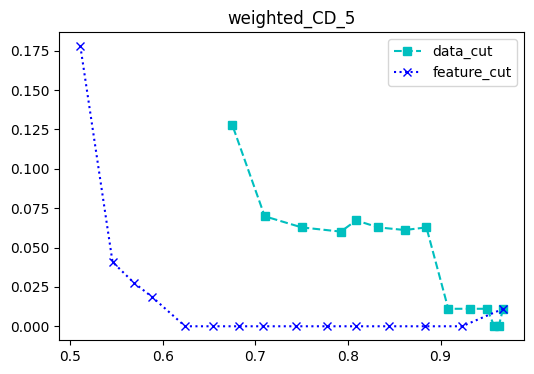

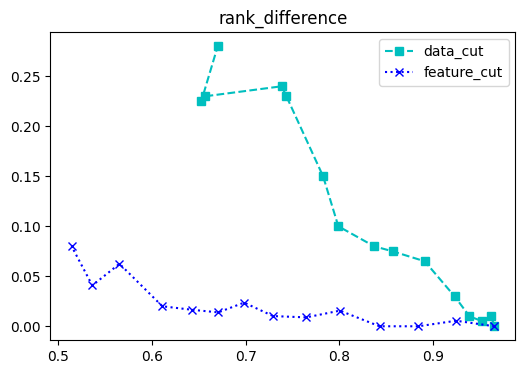

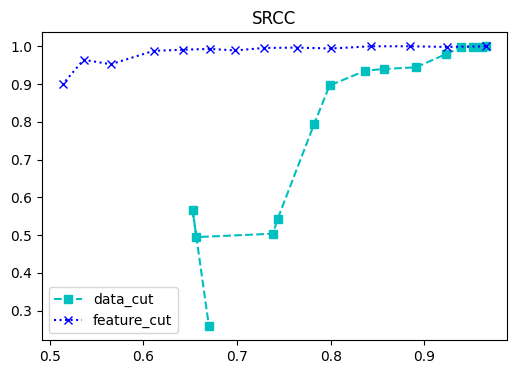

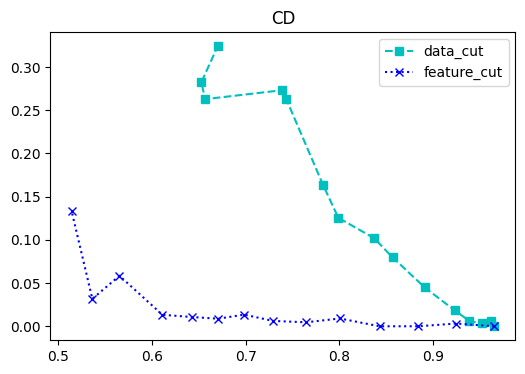

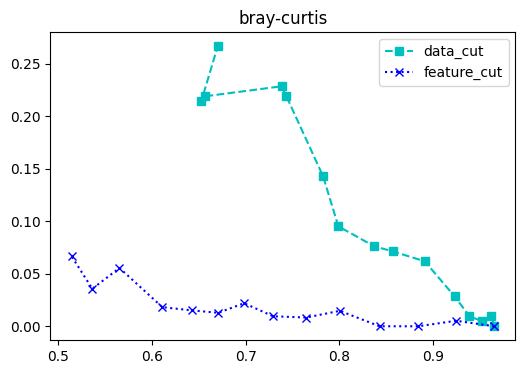

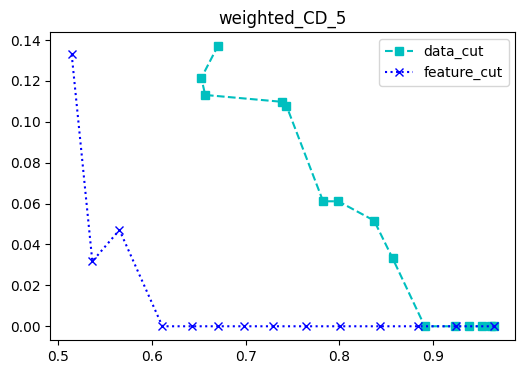

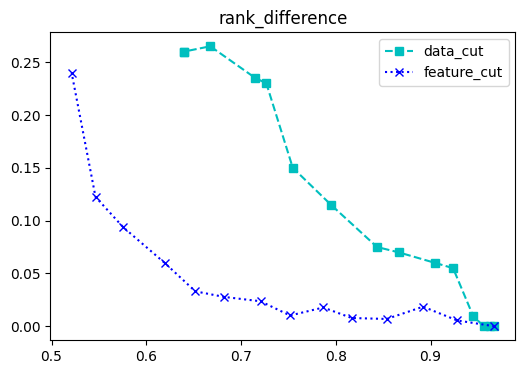

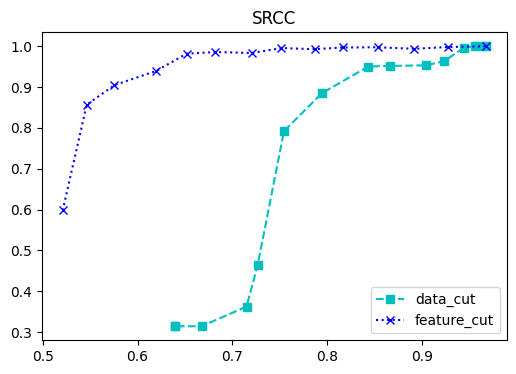

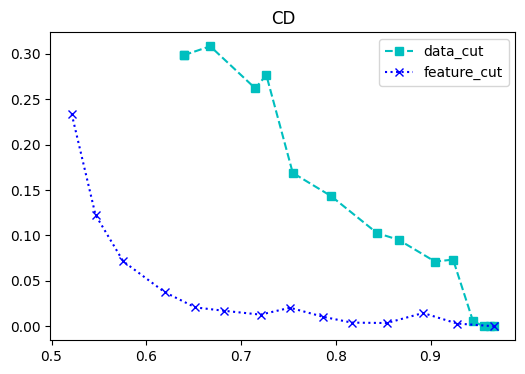

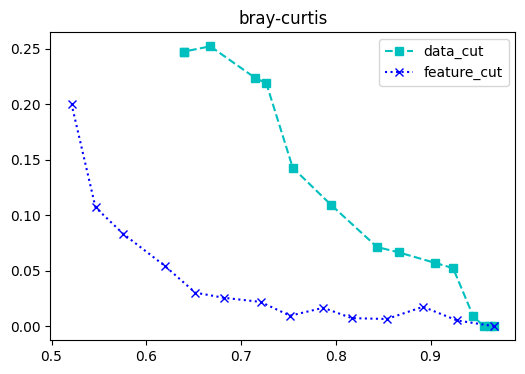

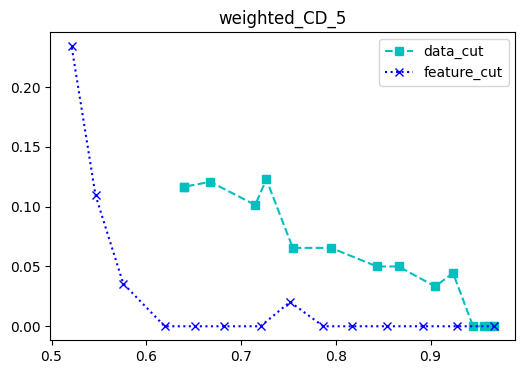

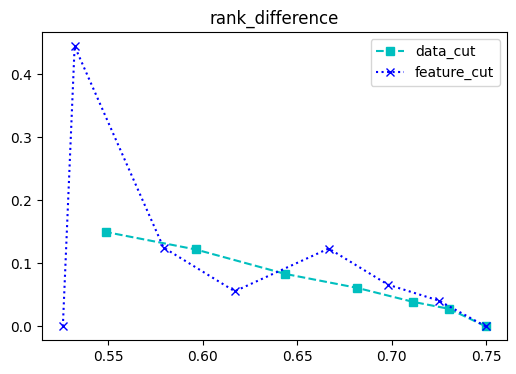

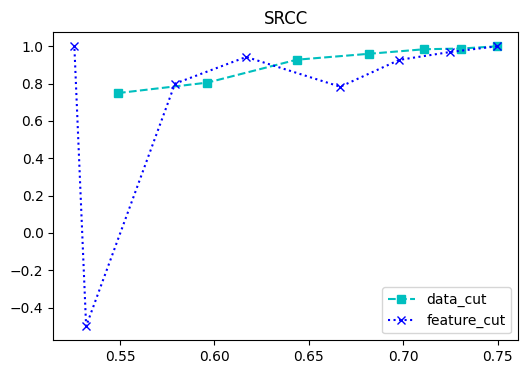

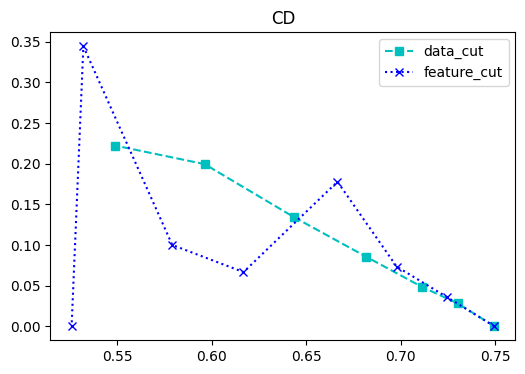

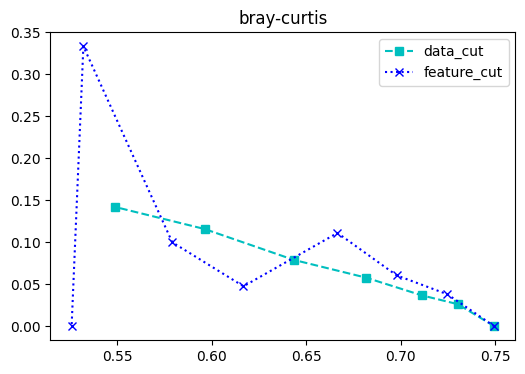

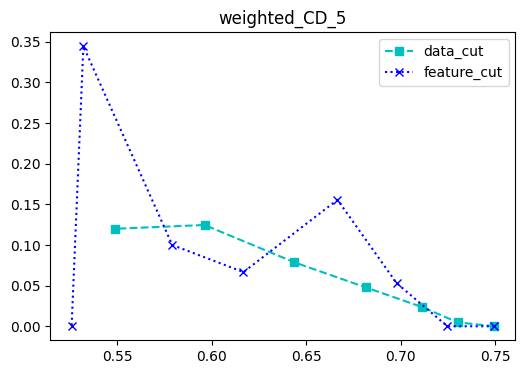

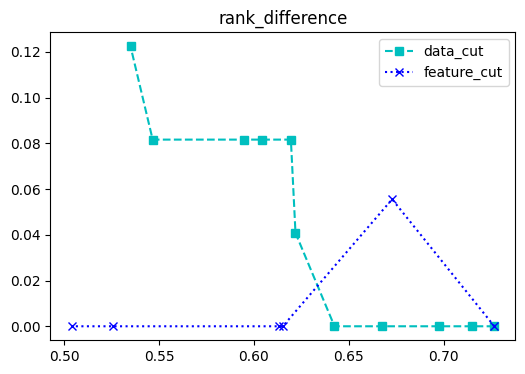

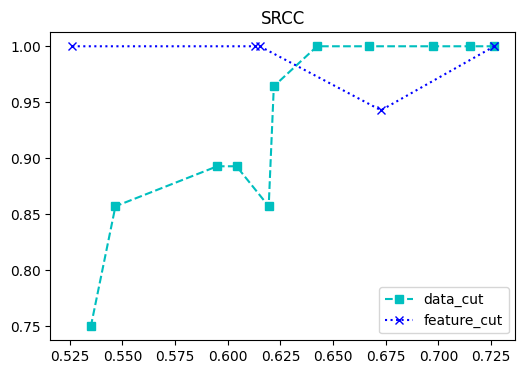

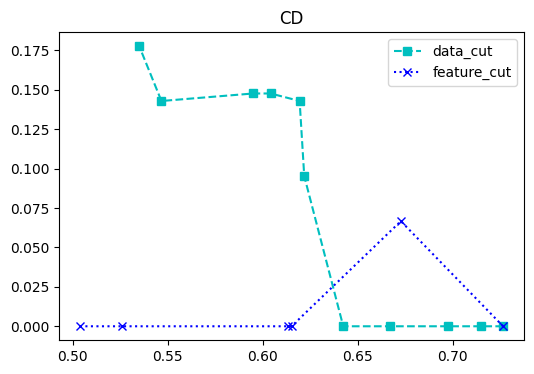

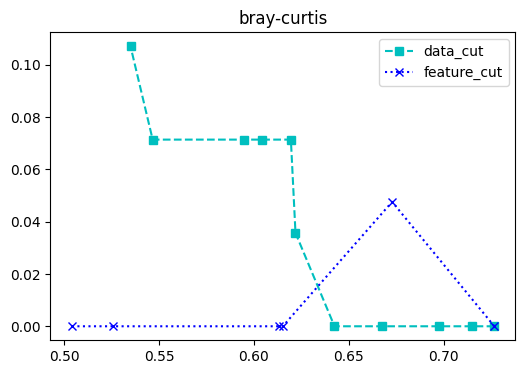

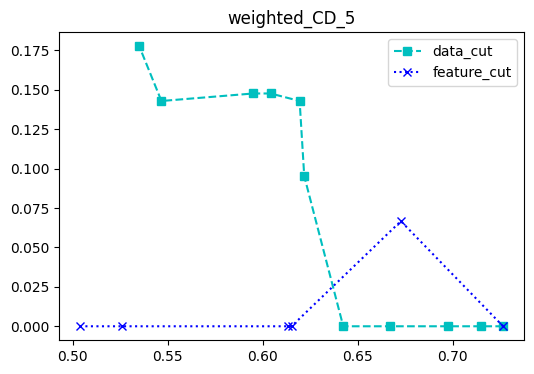

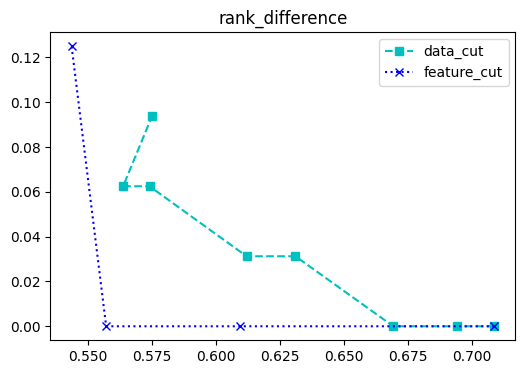

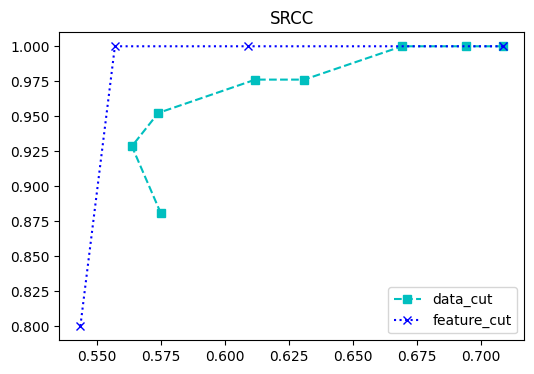

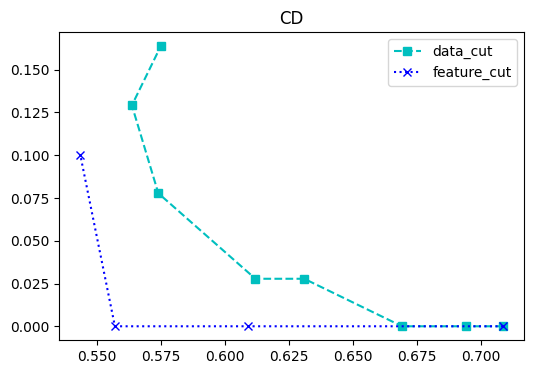

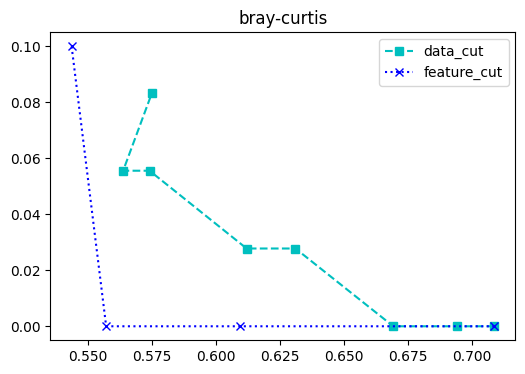

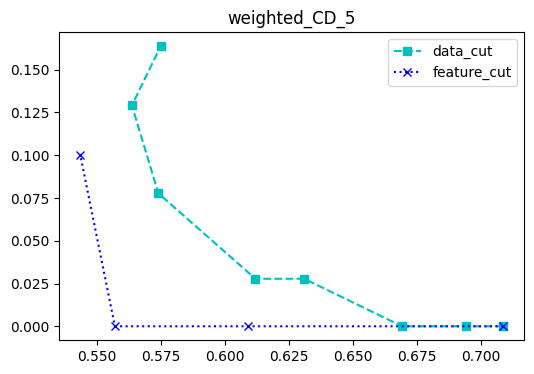

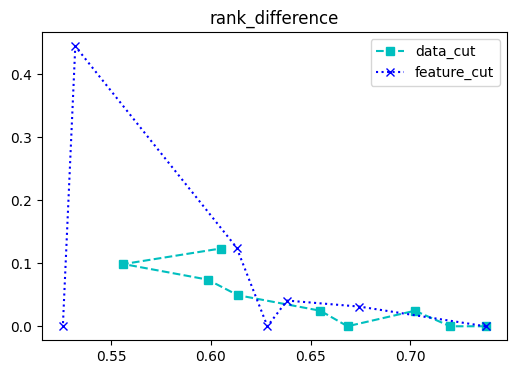

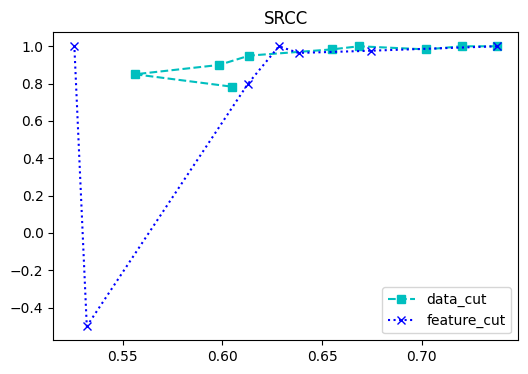

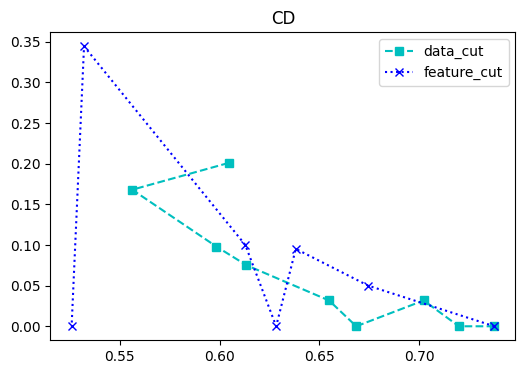

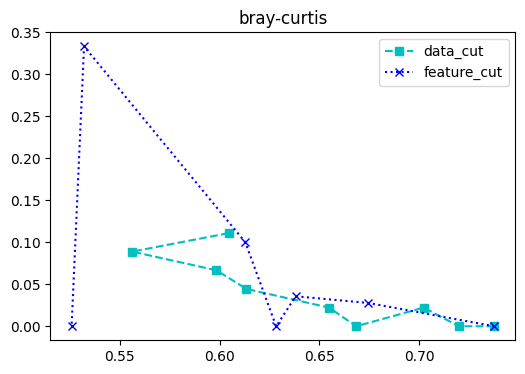

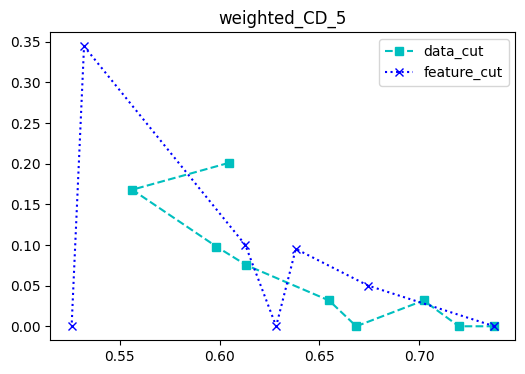

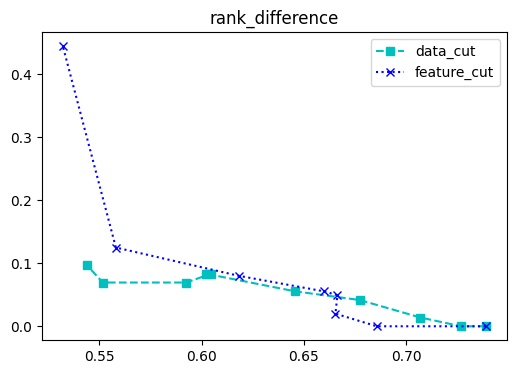

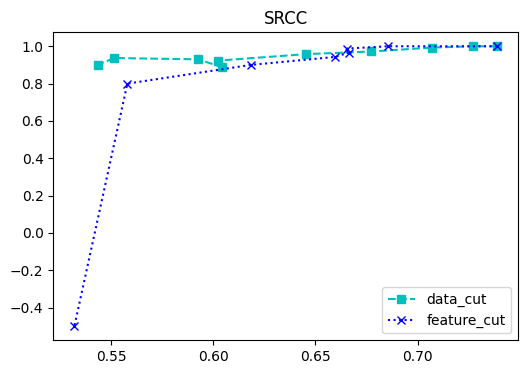

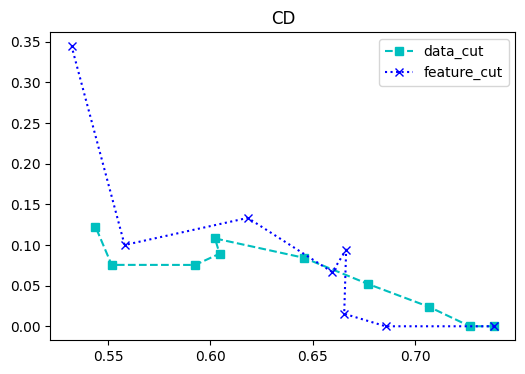

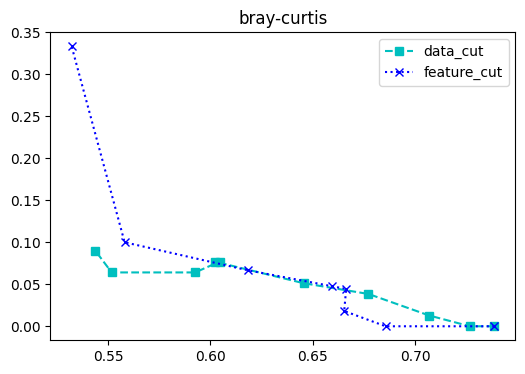

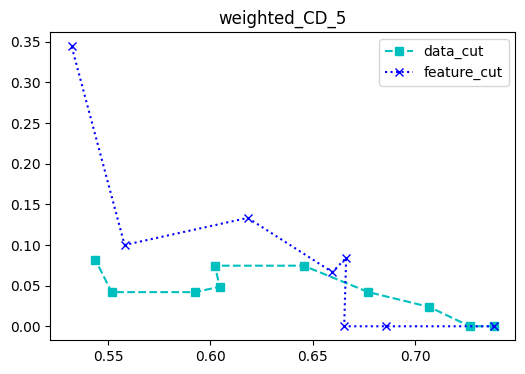

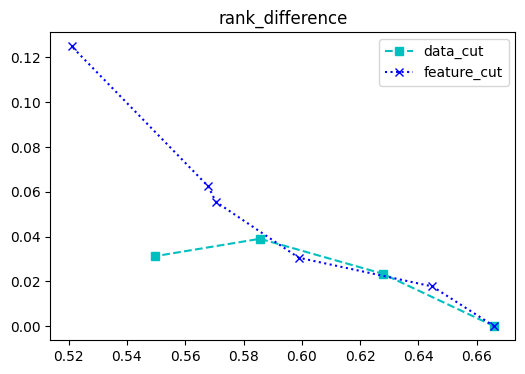

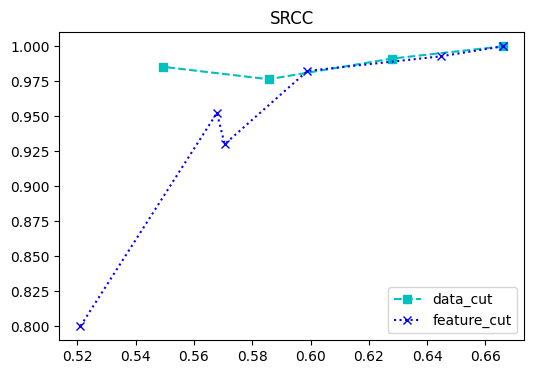

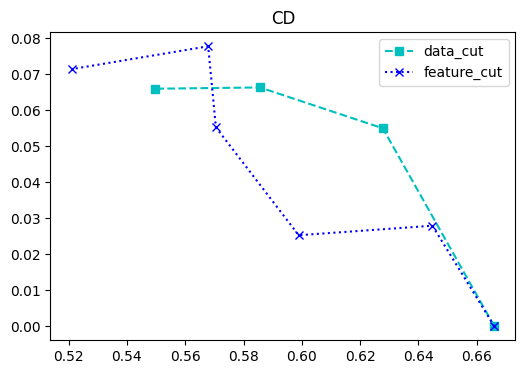

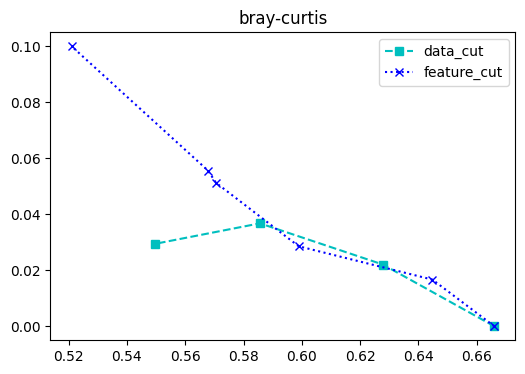

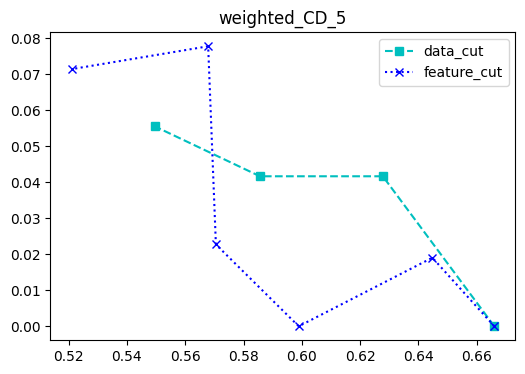

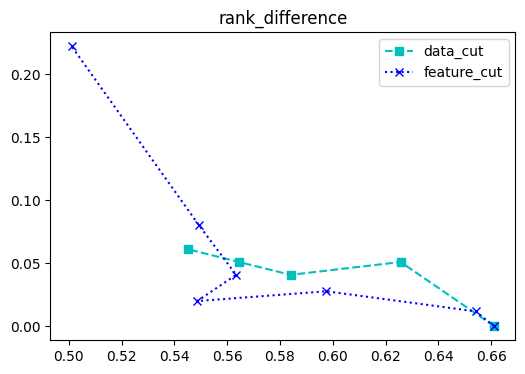

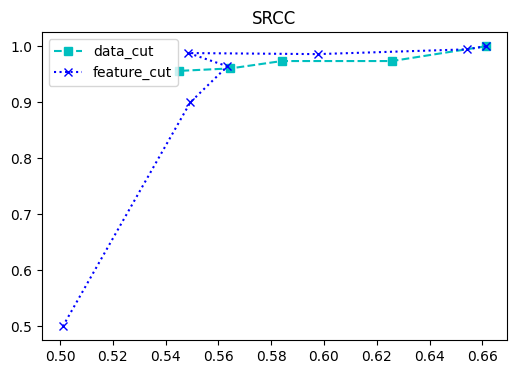

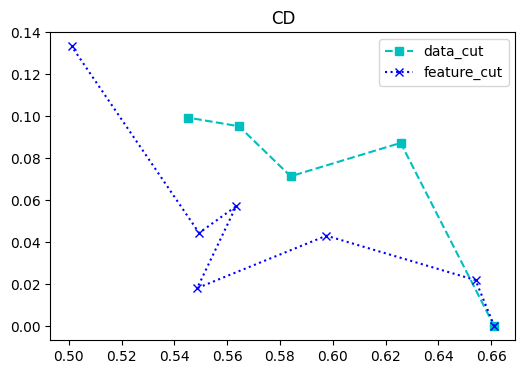

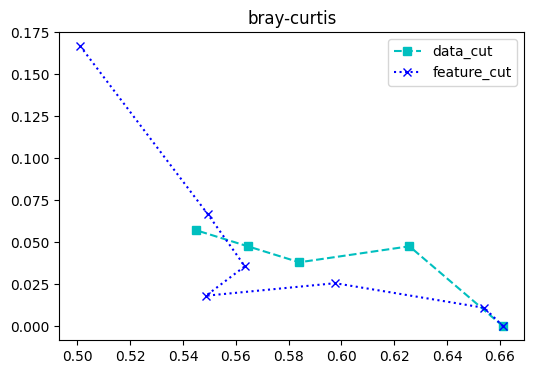

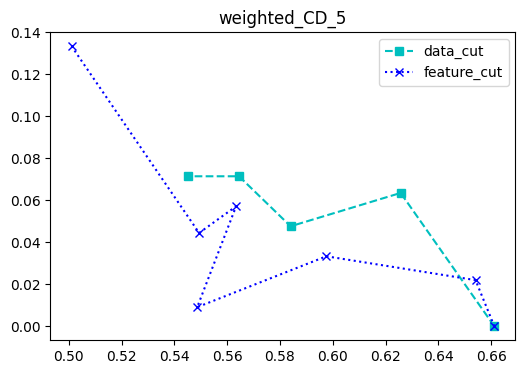

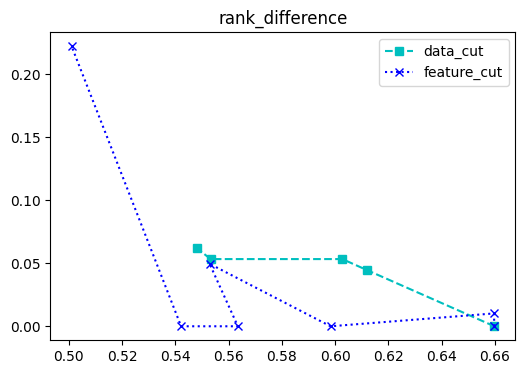

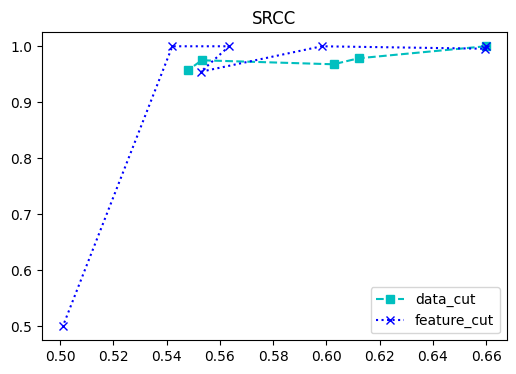

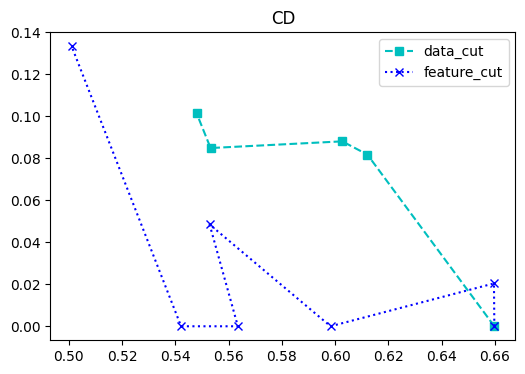

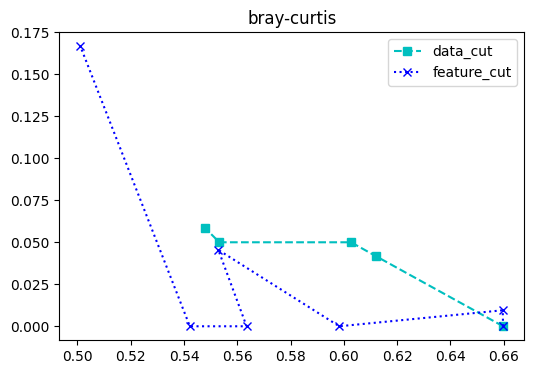

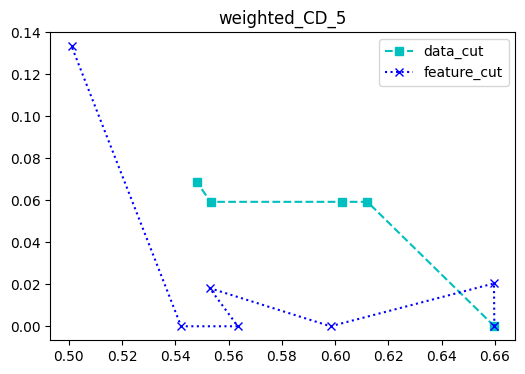

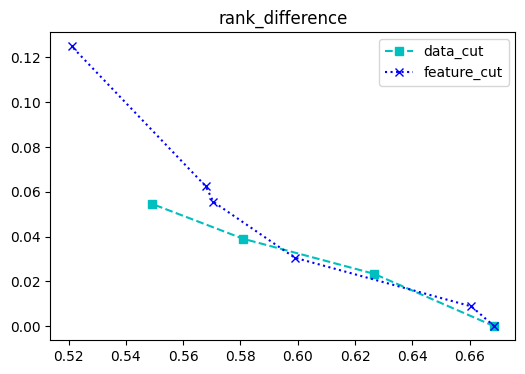

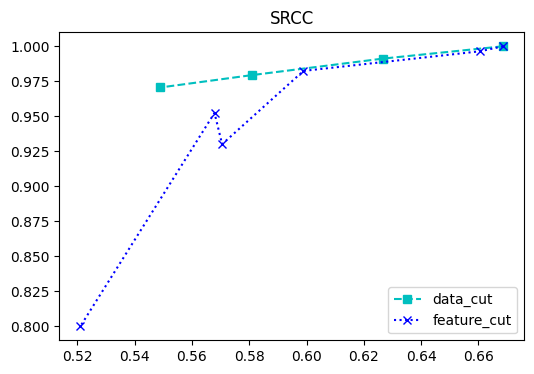

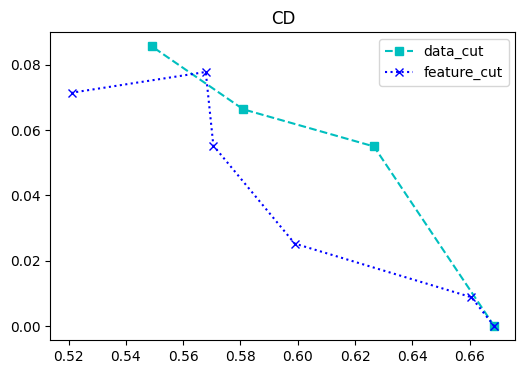

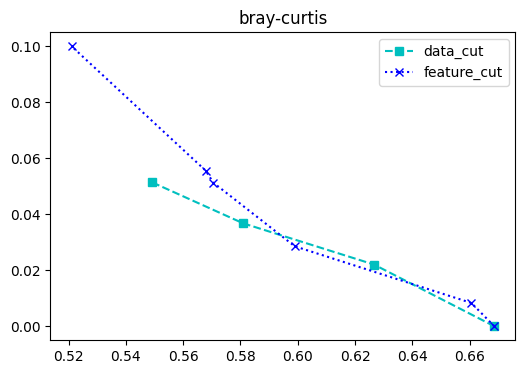

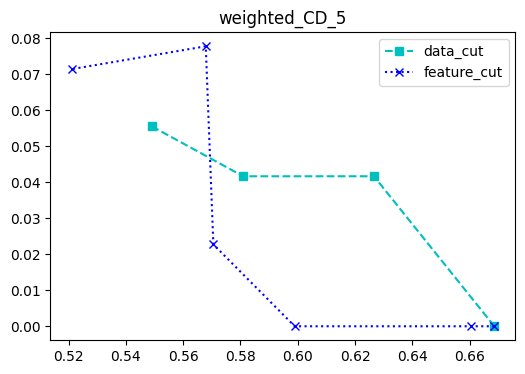

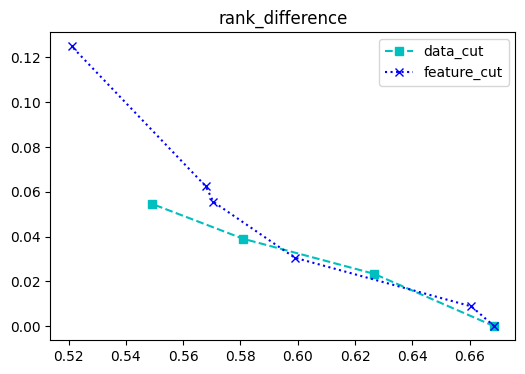

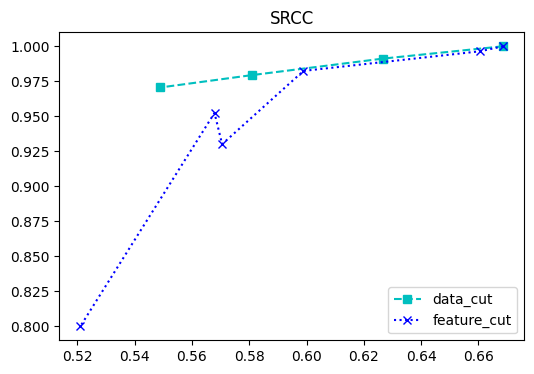

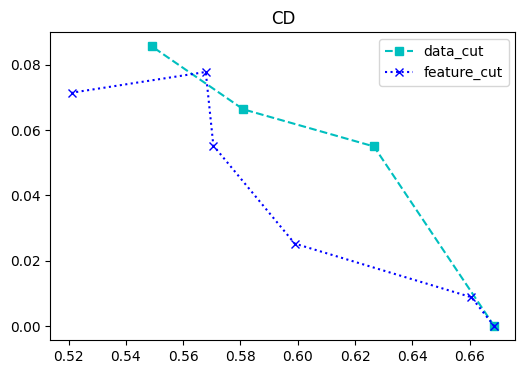

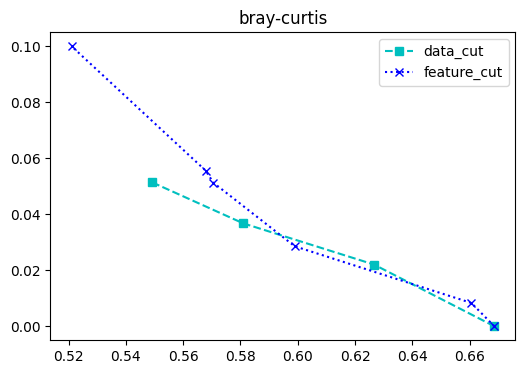

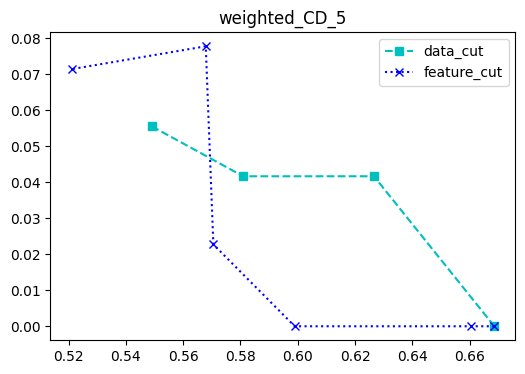

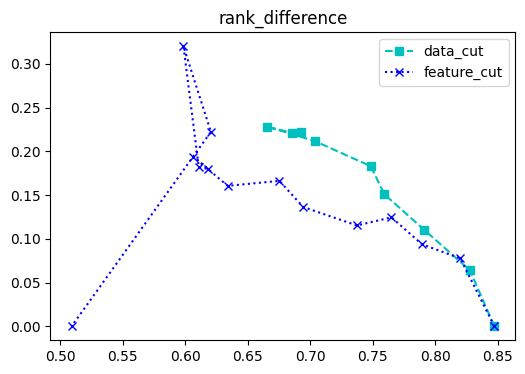

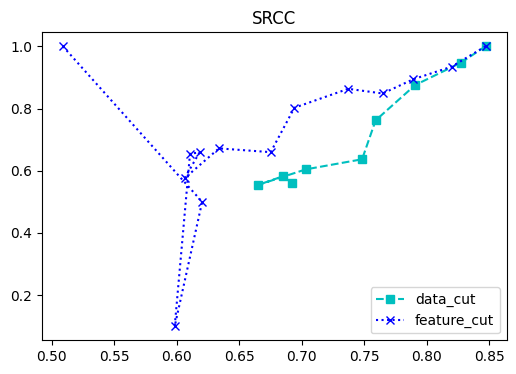

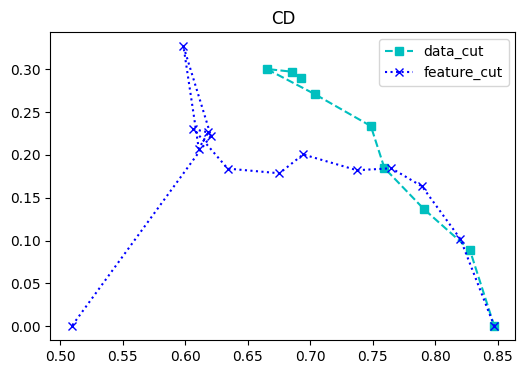

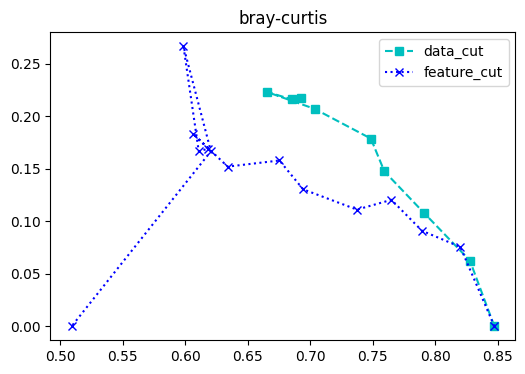

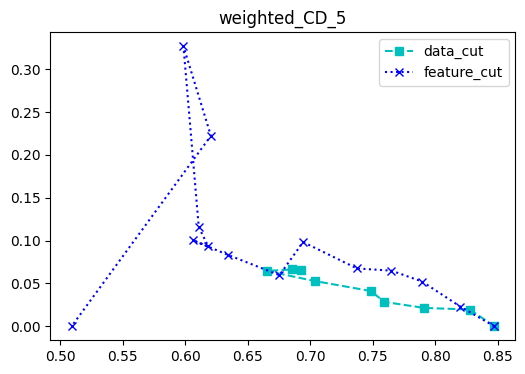

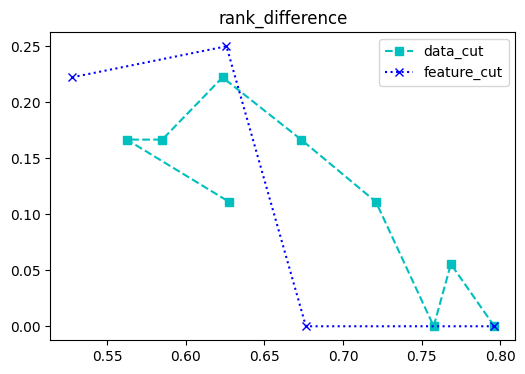

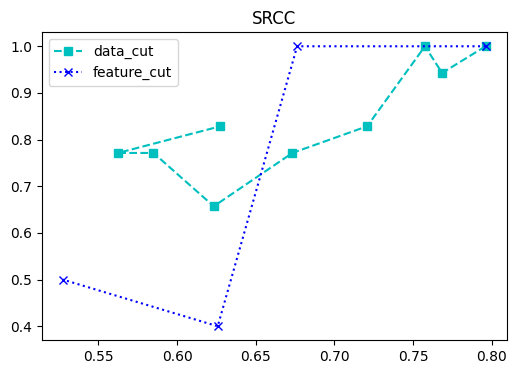

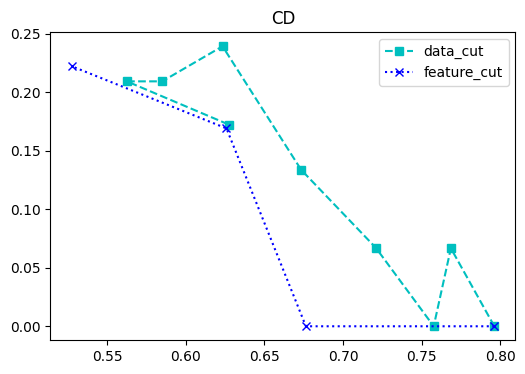

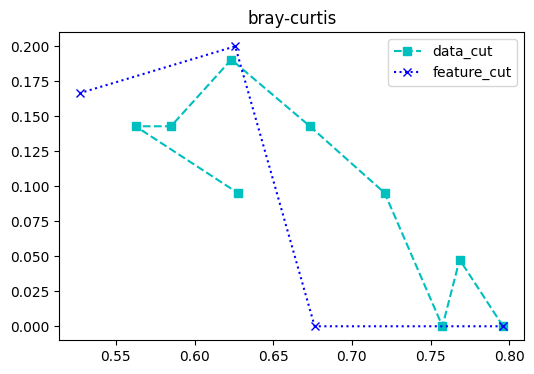

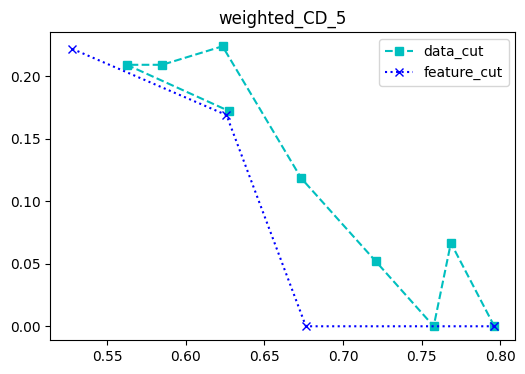

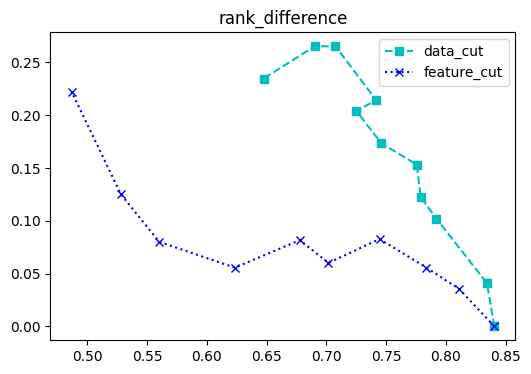

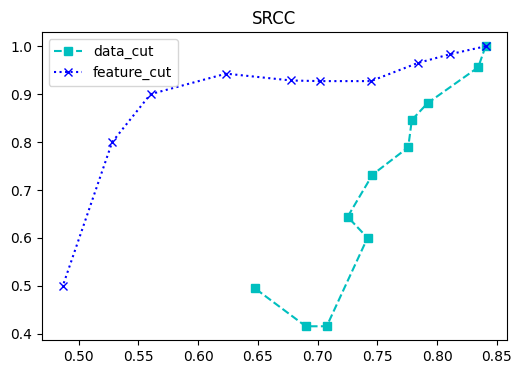

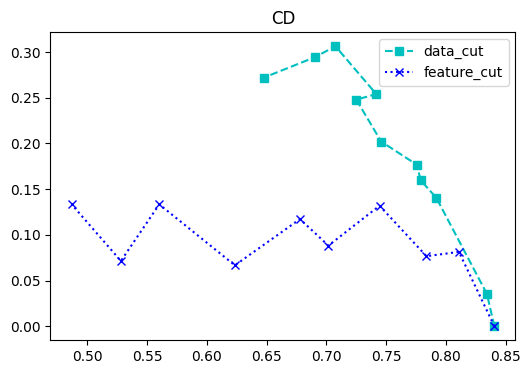

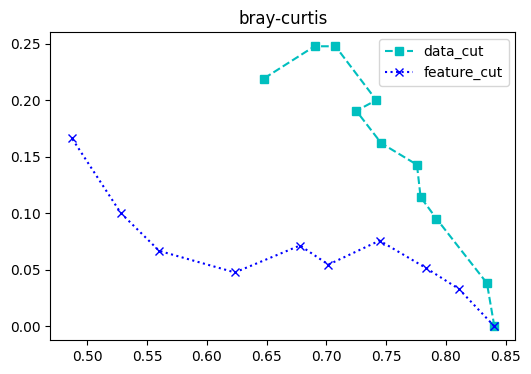

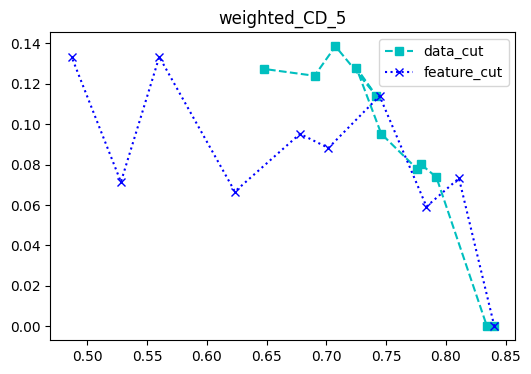

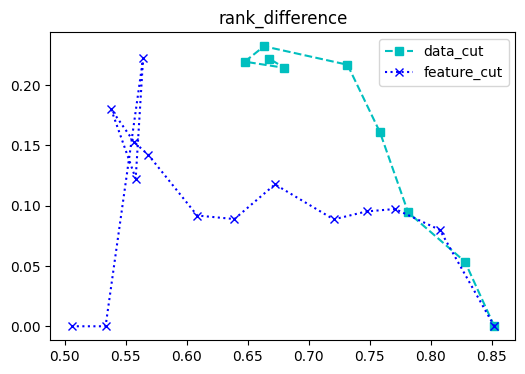

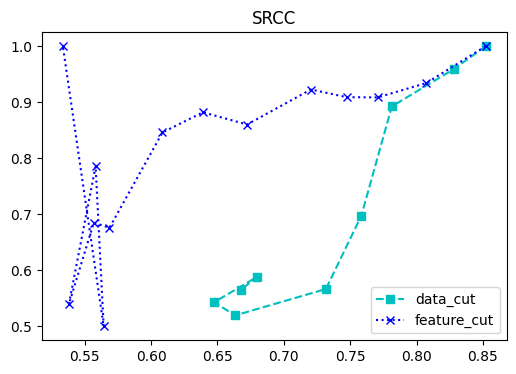

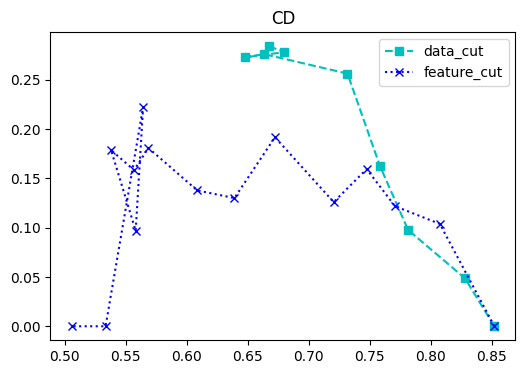

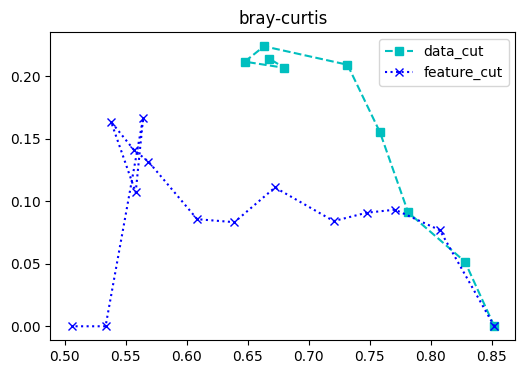

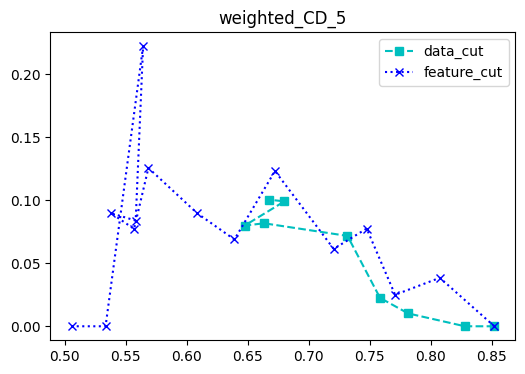

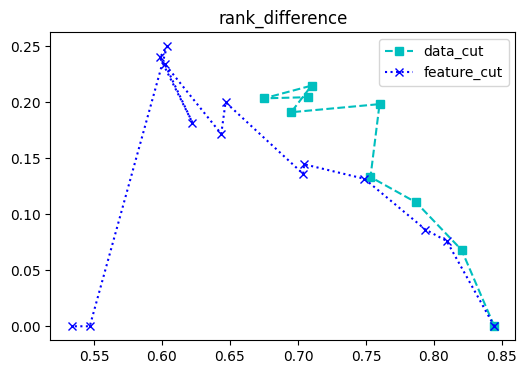

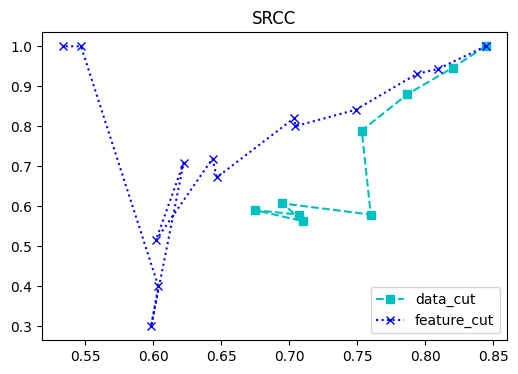

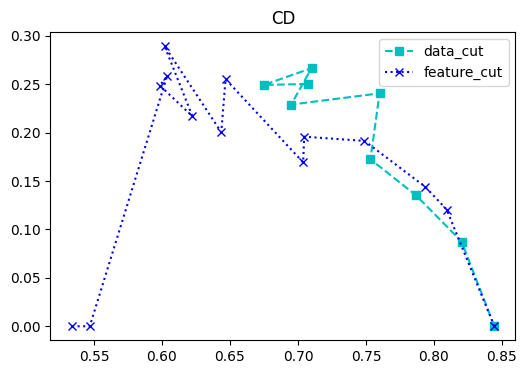

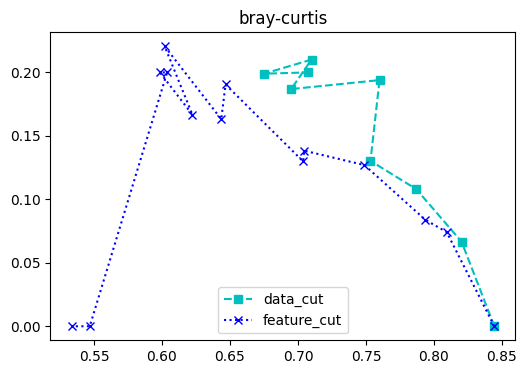

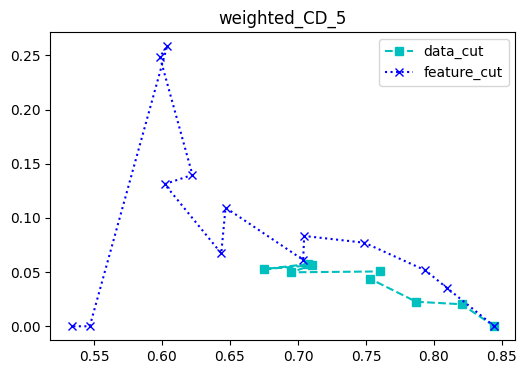

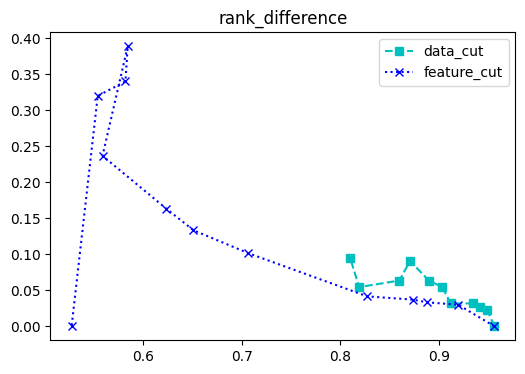

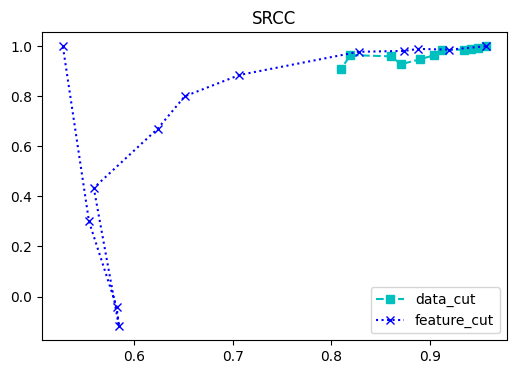

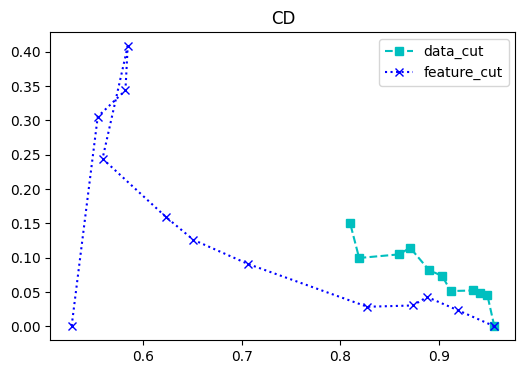

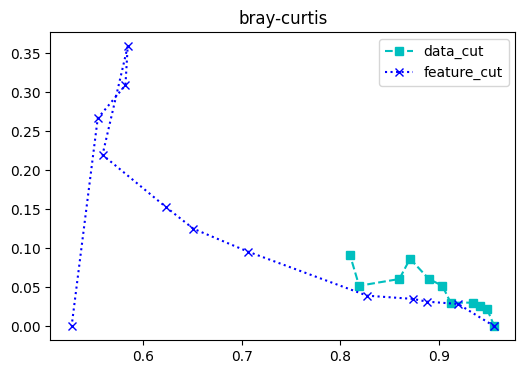

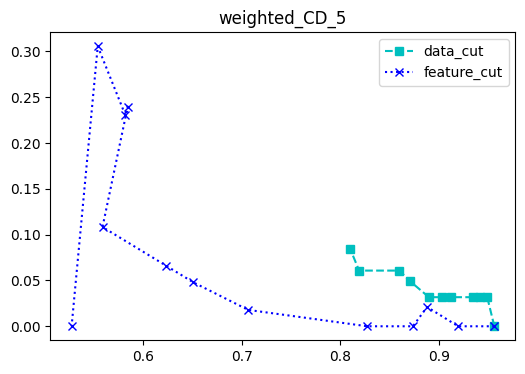

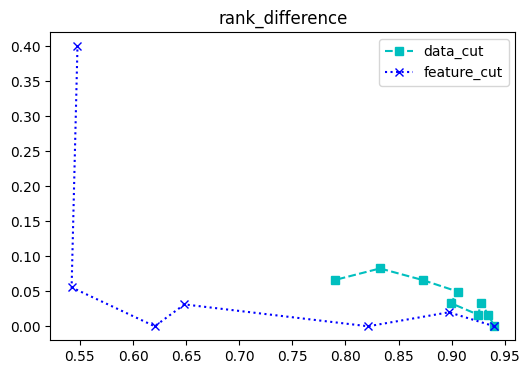

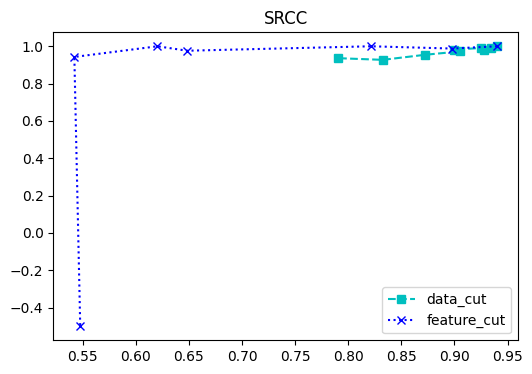

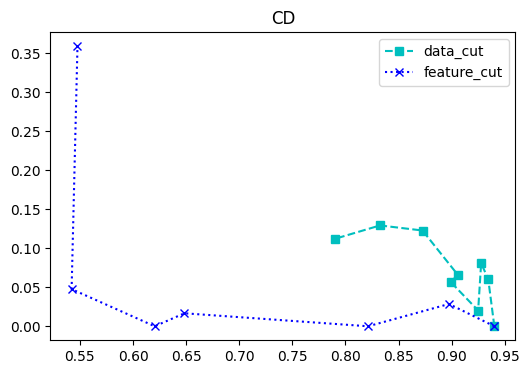

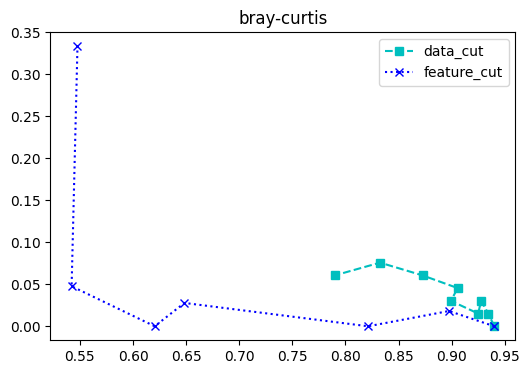

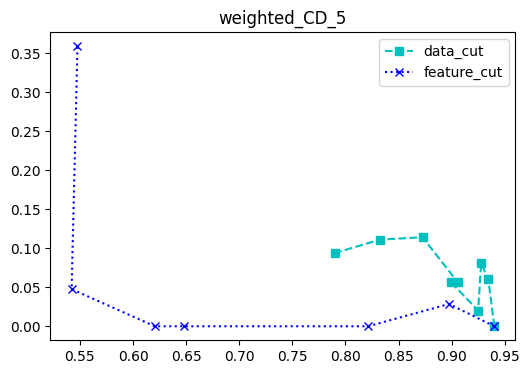

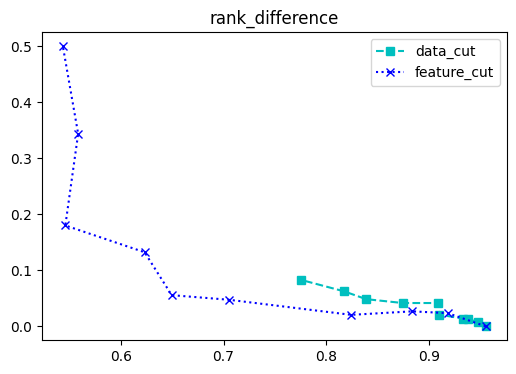

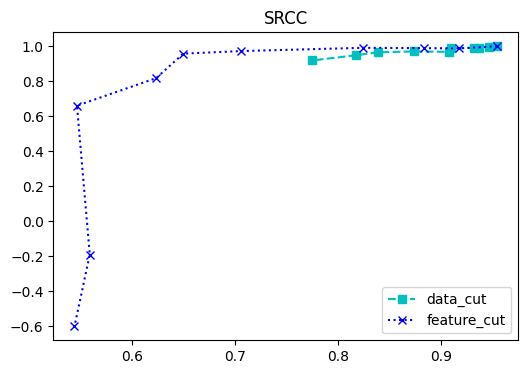

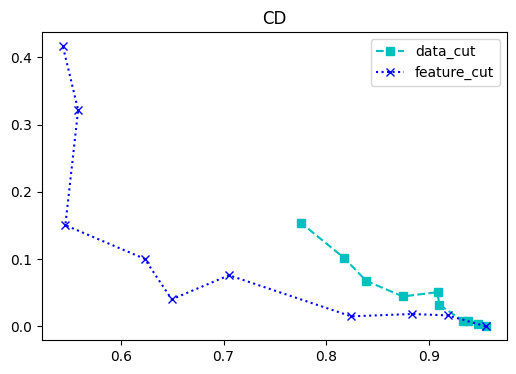

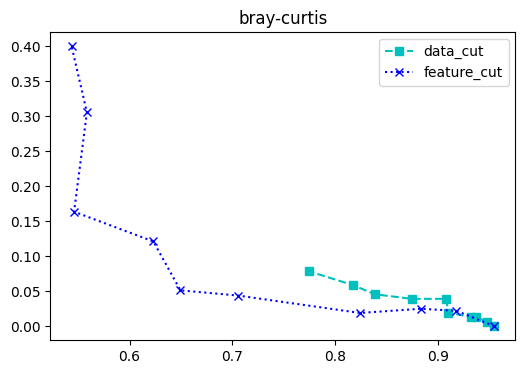

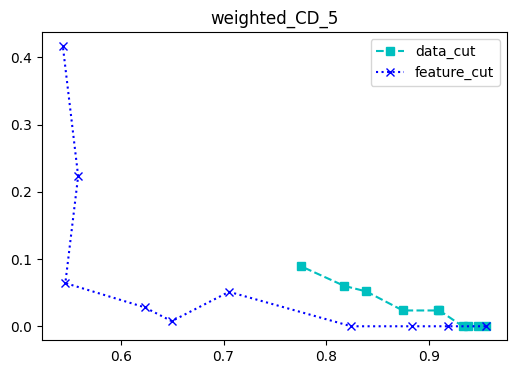

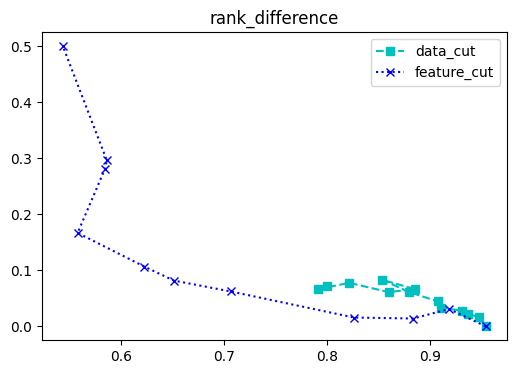

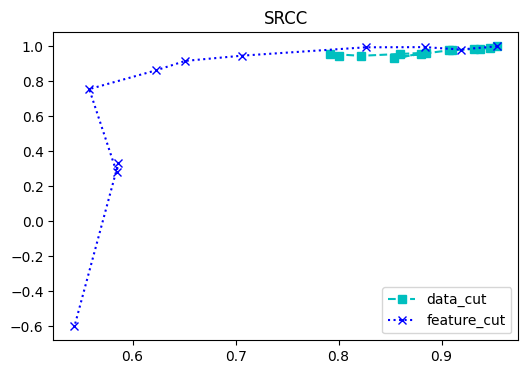

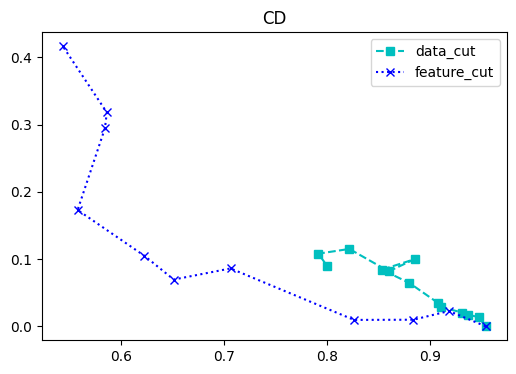

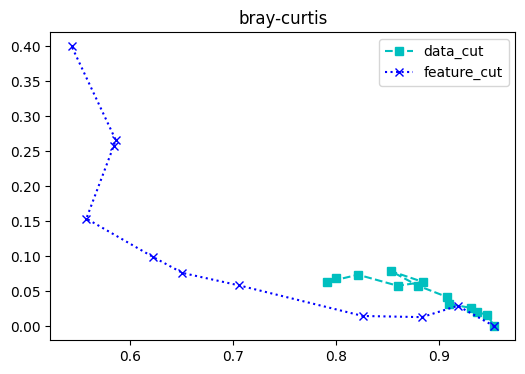

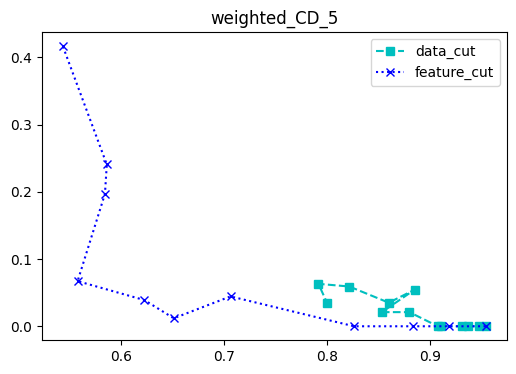

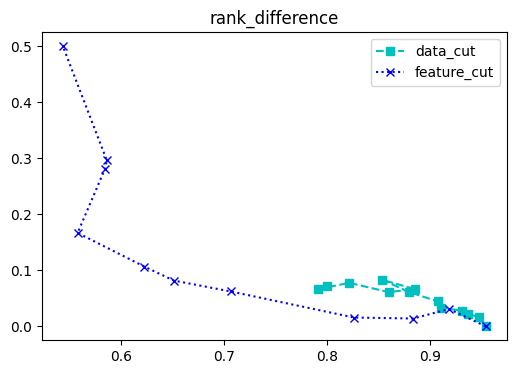

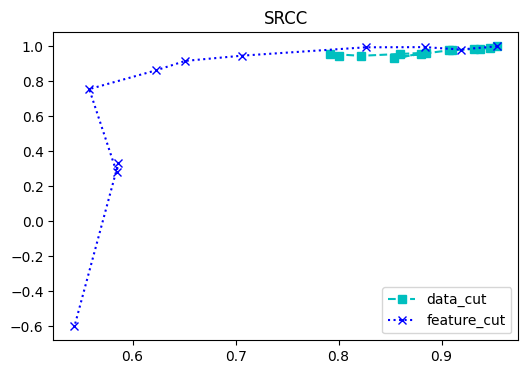

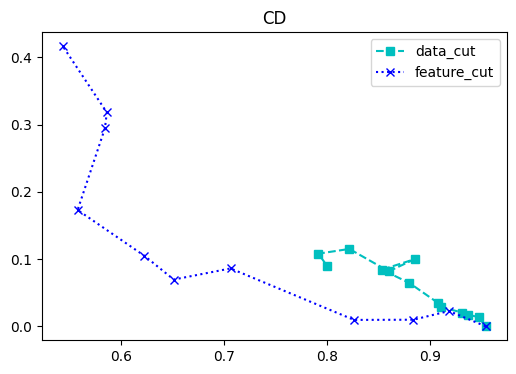

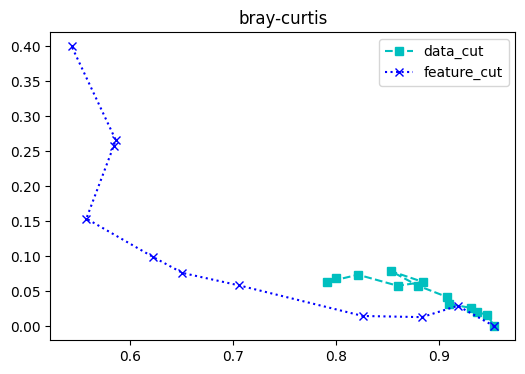

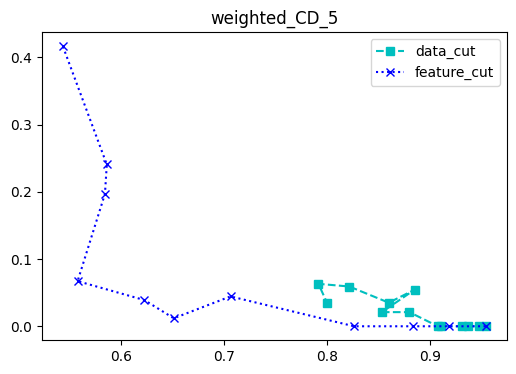

In [3]:
stability_name = ['rank_difference','SRCC','CD','bray-curtis','weighted_CD_5']
cut_algorithm = ["data_cut","feature_cut"]
stability_num = len(stability_name)
for loc_folder in list_data:
    if not "generated" in loc_folder and not "real" in loc_folder:
        continue
    print(loc_folder)
    
    
    for corr in [0,0.3,0.5,0.7,0.9]:
        if not corr==0.0:
            if 'generated' in loc_folder and not 'real' in loc_folder:                
                continue
            loc=loc_folder+"/corr_cut/%s"%corr
        else:
            loc=loc_folder
            

        average_summary_total = []

        for cut_index, cut_name in enumerate(cut_algorithm):




            grid = np.load("../result/"+loc+"/"+cut_name+"/grid.npy")
            average_summary = np.zeros((grid.shape[0],2+stability_num))
            for index, num in enumerate(grid[:,0]):

                if index==0:
                    num = np.int(grid[0,0])
                    feature_importance = np.load("../result/"+loc+"/feature_importance.npy")

                else:
                    num = np.int(num)
                    feature_importance = np.load("../result/"+loc+"/"+cut_name+"/%s_feature_importance.npy"%num)



                current_rank = feature_importance.shape[1]-np.average(feature_importance,axis=0).argsort().argsort()  
                coeff_rank = np.arange(1,feature_importance.shape[1]+1)


                current_rank = current_rank/feature_importance.shape[1]
                coeff_rank = coeff_rank/feature_importance.shape[1]

                

                average_summary[index,0] = grid[index,0] 
                average_summary[index,1] = grid[index,1]


                # average rank difference
                average_summary[index,2] = np.average(np.abs(current_rank-coeff_rank))

                # SRCC
                average_summary[index,3] = stats.spearmanr(coeff_rank, current_rank)[0]

                #CD 
                average_summary[index,4] = distance.canberra(coeff_rank, current_rank)/feature_importance.shape[1]

                #bray-curtis 
                average_summary[index,5] = distance.braycurtis(coeff_rank, current_rank)

                #Weighted CD-forward 5
                weight = np.zeros((feature_importance.shape[1],))
                weight[0:5]=1
                average_summary[index,6] = distance.canberra(coeff_rank, current_rank,weight)/feature_importance.shape[1]





            average_summary_total.append(average_summary)

        cut_algorithm = ["data_cut","feature_cut"]

        for index,name in enumerate(stability_name):



            if not loc in os.listdir(os.getcwd()+"/stability/"):
                
                if "corr" in loc:
                    try:
                        os.mkdir("stability/%s"%loc[:-4])
                    except:
                        pass
                try:
                    os.mkdir("stability/%s"%loc)
                except:
                    pass




            fig, ax = plt.subplots(figsize=(6,4))
            for cut_index,cut_name in enumerate(cut_algorithm):
                if cut_index == 0 :
                    plt.plot(average_summary_total[cut_index][:,1],average_summary_total[cut_index][:,2+index],'cs--',label = cut_name)
                elif cut_index == 1:
                    plt.plot(average_summary_total[cut_index][:,1],average_summary_total[cut_index][:,2+index],'bx:',label = cut_name)
        #             else :
        #                 plt.plot(average_summary_total[cut_index][:,1],average_summary_total[cut_index][:,2+index],'rx:',label = cut_name)



            plt.title(name)
            plt.legend()
            plt.savefig('stability/%s/%s.jpg'%(loc,name), dpi=600, bbox_inches='tight')
        #     plt.show()

        for cut_index,cut_name in enumerate(cut_algorithm):
            np.save('stability/%s/%s'%(loc,cut_name),average_summary_total[cut_index])



# Range Detection

In [19]:
list_data = ['real_1_DR', 'real_2_TS', 'real_3_HT', 'real_4_MS']

In [22]:
total_range_min = np.zeros((4,4,2))
total_range_max = np.zeros((4,4,2))

In [32]:
total_stability_data = []
total_stability_feature = []
total_name_list = []


regression_data  = pd.DataFrame()
regression_corr_data  = pd.DataFrame()




cut_algorithm = ["data_cut","feature_cut"]

for loc_folder in list_data:
    if  "generated" in loc_folder:
        continue


    total_name_list.append(loc)
    cut_algorithm = ["data_cut","feature_cut"]
    stability_name_total = ['rank difference','SRCC','CD','Bray-Curtis','weighted_CD_5']


    stability_data  = np.load('../graph/stability/%s/%s.npy'%(loc,cut_algorithm[0]))
    stability_feature = np.load('../graph/stability/%s/%s.npy'%(loc,cut_algorithm[1]))


    stability_data = stability_data[np.logical_not(np.isnan(stability_data[:,1])),:]
    stability_feature = stability_feature[np.logical_not(np.isnan(stability_feature[:,1])),:]


    arrange_arr= stability_data[:,1].argsort()[::-1]
    stability_data = stability_data[arrange_arr,:]


    arrange_arr = stability_feature[:,1].argsort()[::-1]
    stability_feature = stability_feature[arrange_arr,:]


    stability_data= stability_data[1:,:]
    stability_feature= stability_feature[1:,:]

    if not "generated_" in loc:


        ## cut grid where the AUC is under 0.55
        if np.min(stability_feature[:,1])<0.55:
            left_loc = (stability_feature[:,1]>0.55)
            stability_feature = stability_feature[left_loc,:]



        if np.min(stability_data[:,1])<0.55:
            left_loc = (stability_data[:,1]>0.55)
            stability_data = stability_data[left_loc,:]


        ##cut grid where the AUC is far from the other's minimum
        if np.min(stability_data[:,1])>np.min(stability_feature[:,1]):
            cut_index =  np.argmin(stability_feature[:,1]>np.min(stability_data[:,1]))+1
            stability_feature = stability_feature[:cut_index,:]

        elif np.min(stability_feature[:,1])>np.min(stability_data[:,1]):
            cut_index =  np.argmin(stability_data[:,1]>np.min(stability_feature[:,1]))+1
            stability_data = stability_data[:cut_index,:]


        ##cut grid where the AUC is far from the other's maximum
        if np.max(stability_data[:,1])>np.max(stability_feature[:,1]):            
            cut_index =  np.argmin(stability_data[:,1]>np.max(stability_feature[:,1]))-1                
            stability_data = stability_data[cut_index:,:]

        elif np.max(stability_feature[:,1])>np.max(stability_data[:,1]):            
            cut_index =  np.argmin(stability_feature[:,1]>np.max(stability_data[:,1]))-1                
            stability_feature = stability_feature[cut_index:,:]





    total_stability_data.append(stability_data)
    total_stability_feature.append(stability_feature)
#         cut_algorithm = ["Data Removal","Feature Removal"]
    cut_algorithm = ["Samples Removal","Features Removal"]
    stability_name_total = ['Rank Difference','Spearman%s Rank Correlation Coefficient'%("'s"),'Canberra Distance','Bray-Curtis Dissimilarity']

    
        
    for index,stability_name in enumerate(stability_name_total):

        
        
        
        min_auc = np.min(np.concatenate((stability_data[:,1],stability_feature[:,1])))
        if total_range_min[int(loc_folder[5])-1,index,0]==0 or  total_range_min[int(loc_folder[5])-1,index,0]>min_auc:
            total_range_min[int(loc_folder[5])-1,index,0] =  min_auc
            
            
        min_stability = np.min(np.concatenate((stability_data[:,2+index],stability_feature[:,2+index])))
        if total_range_min[int(loc_folder[5])-1,index,1]==0 or  total_range_min[int(loc_folder[5])-1,index,1]>min_stability:
            total_range_min[int(loc_folder[5])-1,index,1] =  min_stability
            
        max_auc = np.max(np.concatenate((stability_data[:,1],stability_feature[:,1])))
        if total_range_max[int(loc_folder[5])-1,index,0]==0 or  total_range_max[int(loc_folder[5])-1,index,0]<max_auc:
            total_range_max[int(loc_folder[5])-1,index,0] =  max_auc
            
            
        max_stability = np.max(np.concatenate((stability_data[:,2+index],stability_feature[:,2+index])))
        if total_range_max[int(loc_folder[5])-1,index,1]==0 or  total_range_max[int(loc_folder[5])-1,index,1]<max_stability:
            total_range_max[int(loc_folder[5])-1,index,1] =  max_stability
            



# Trimming

real_1_DR


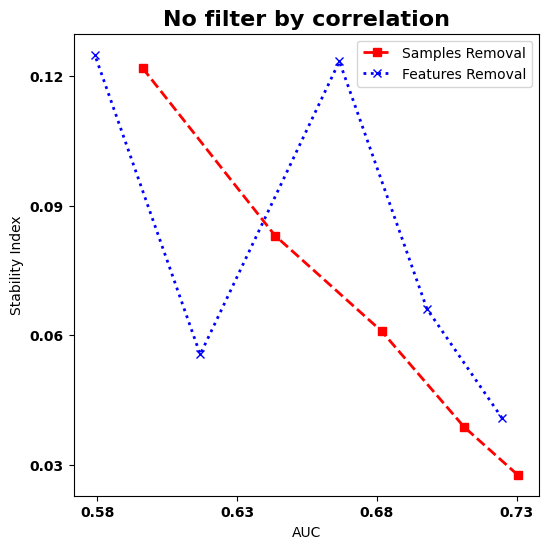

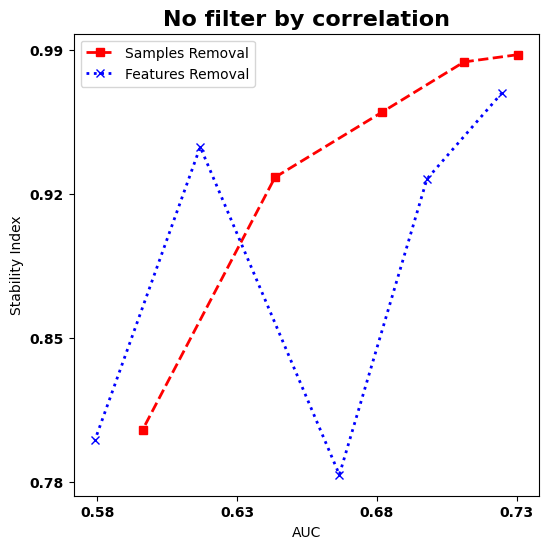

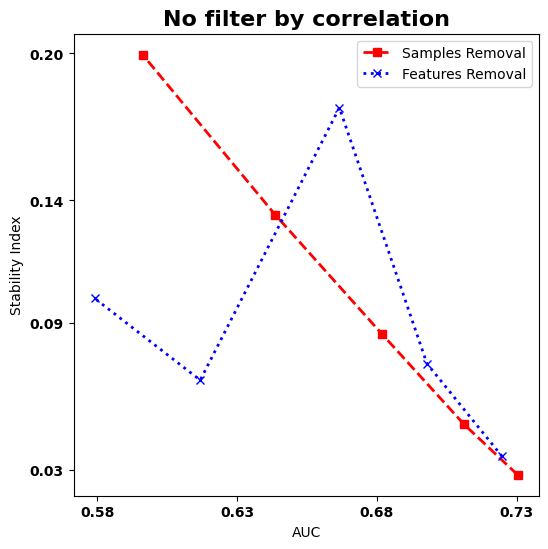

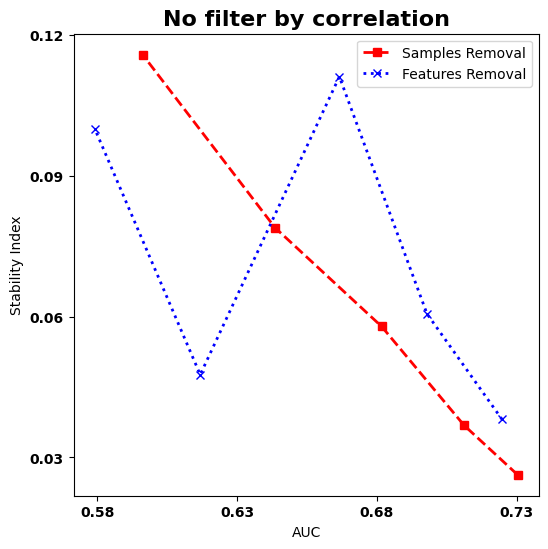

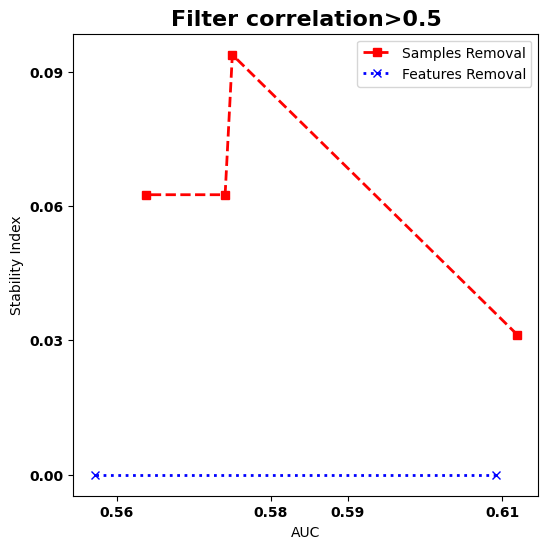

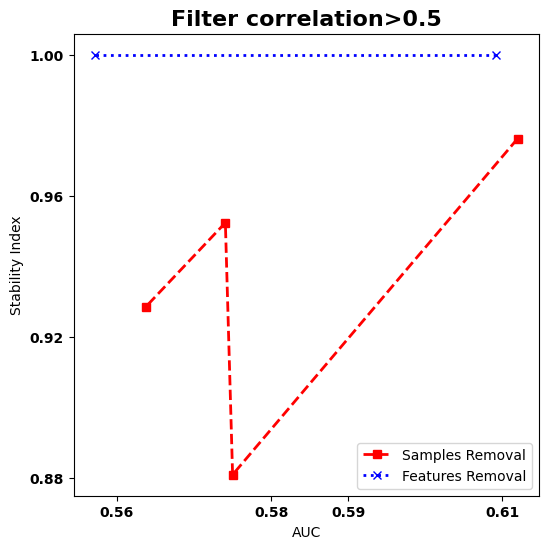

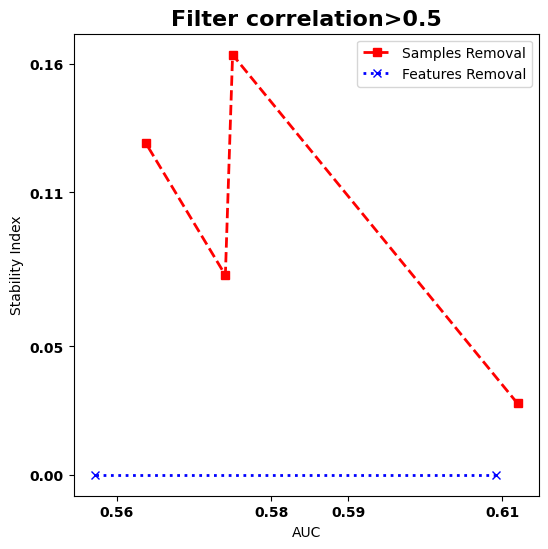

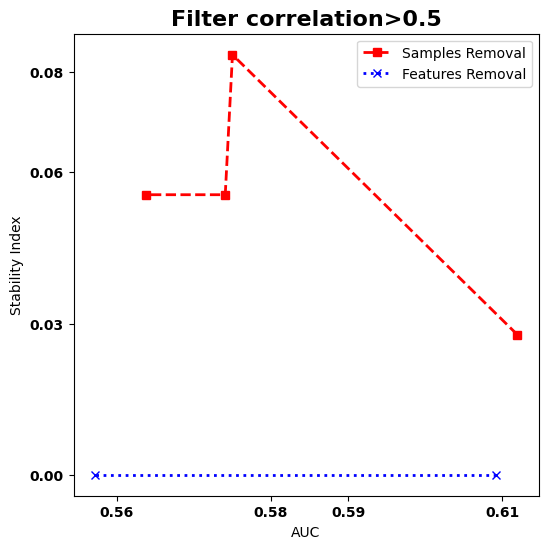

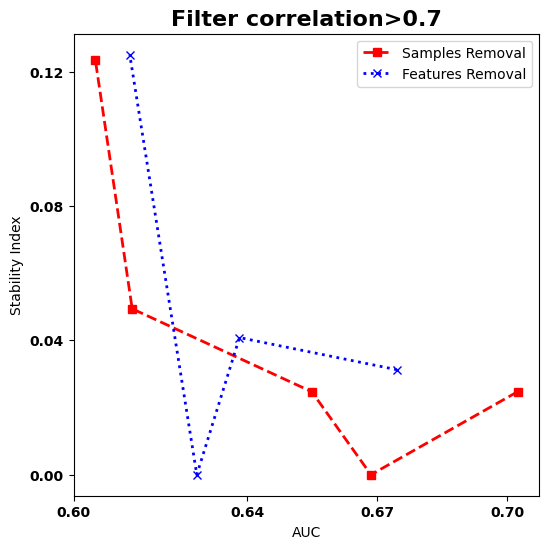

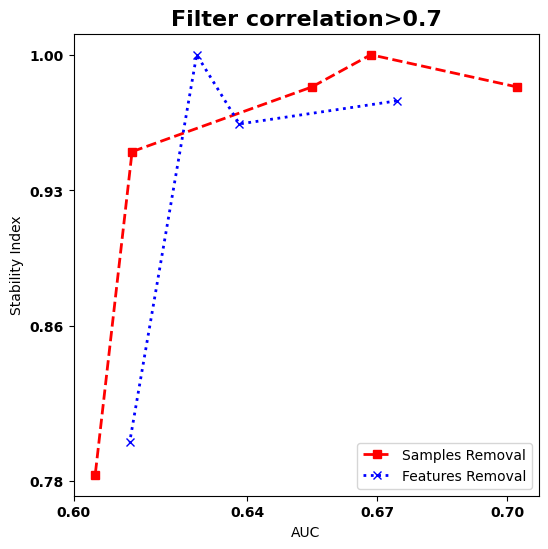

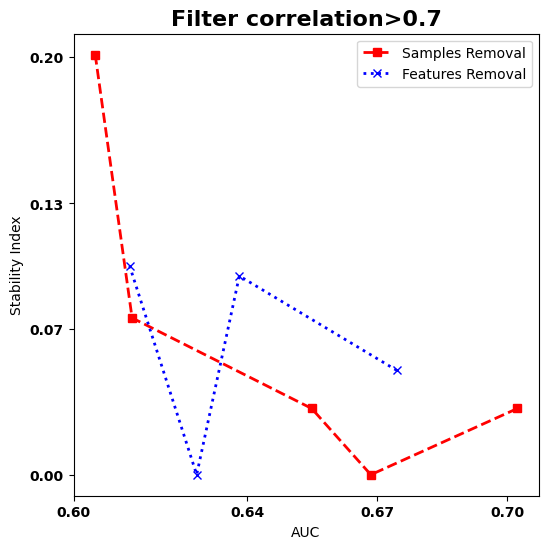

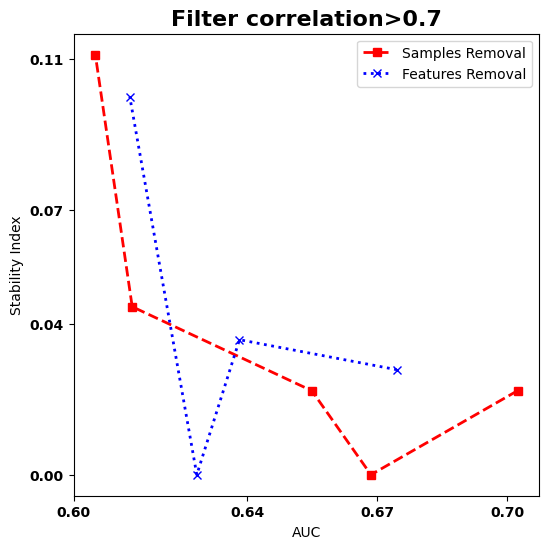

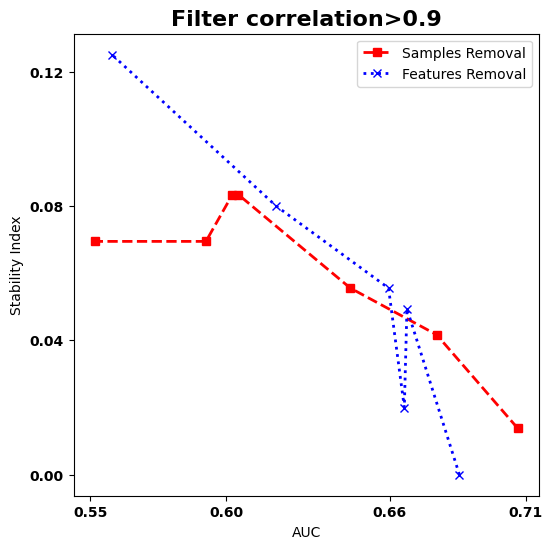

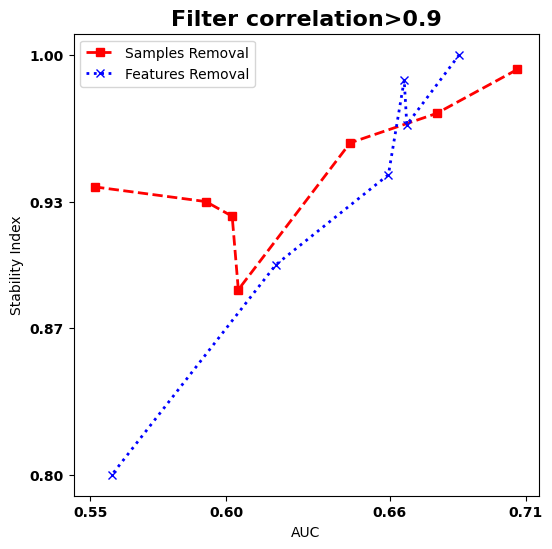

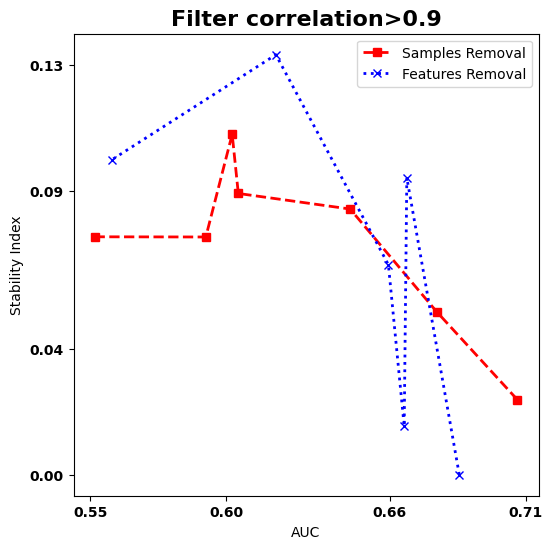

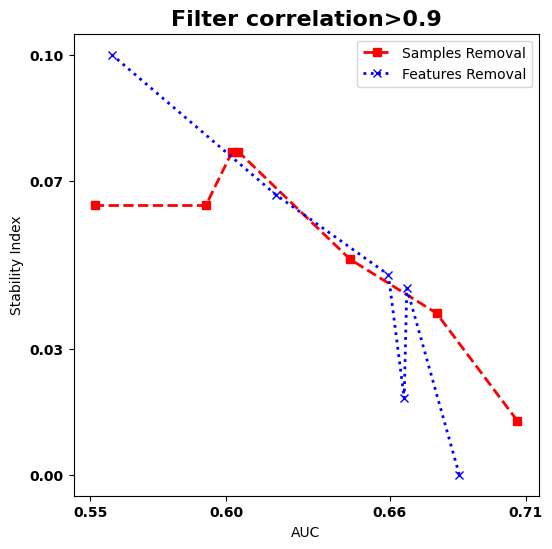

real_2_TS


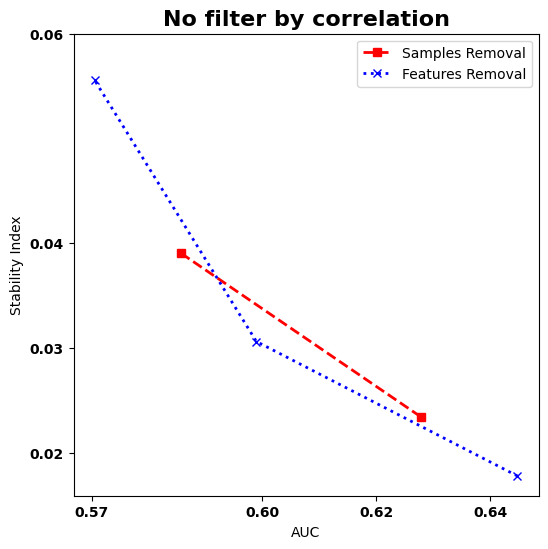

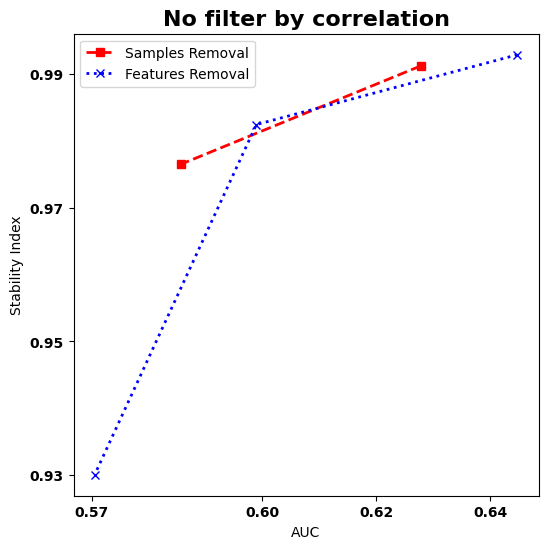

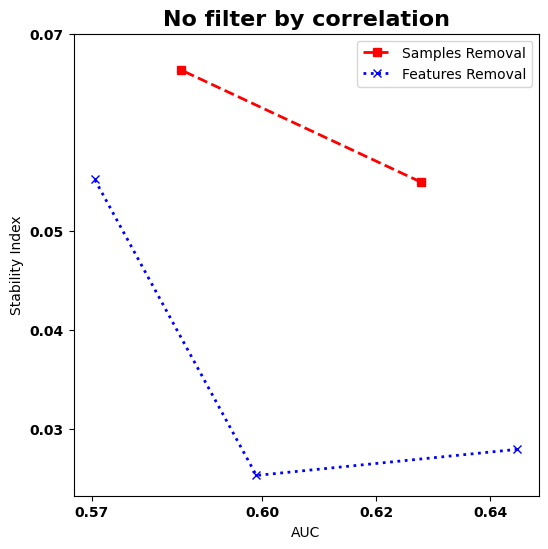

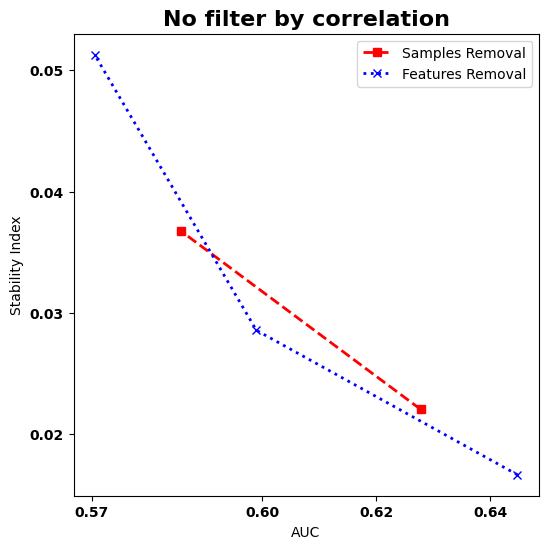

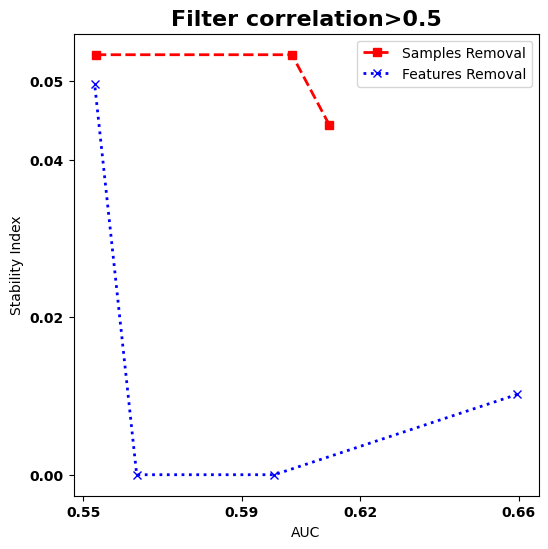

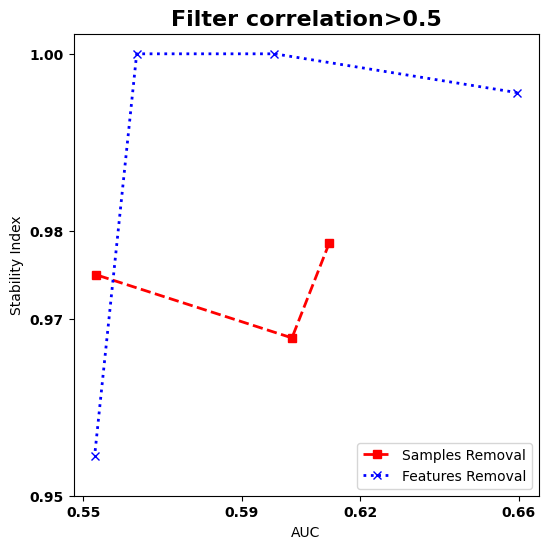

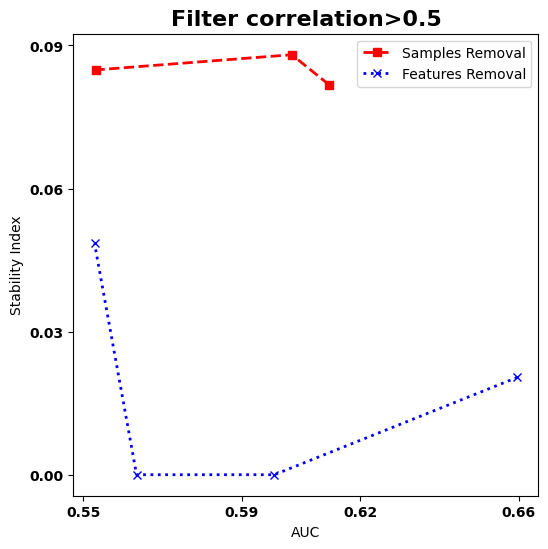

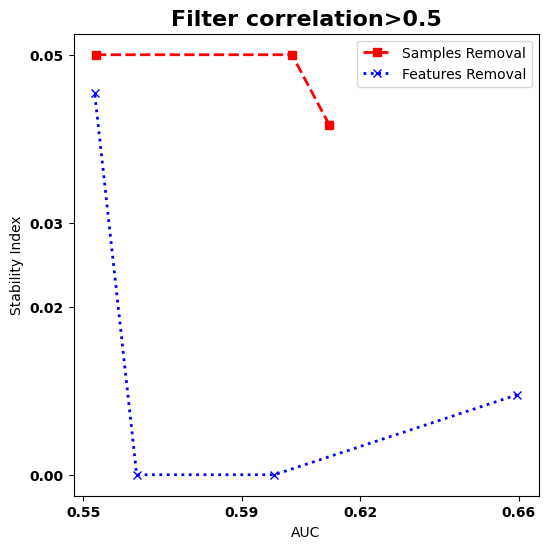

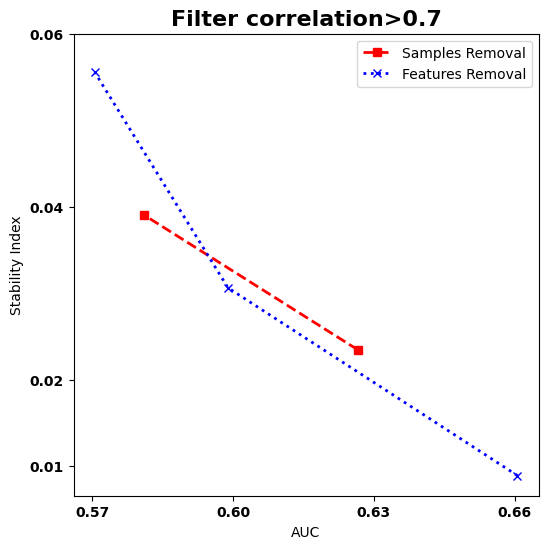

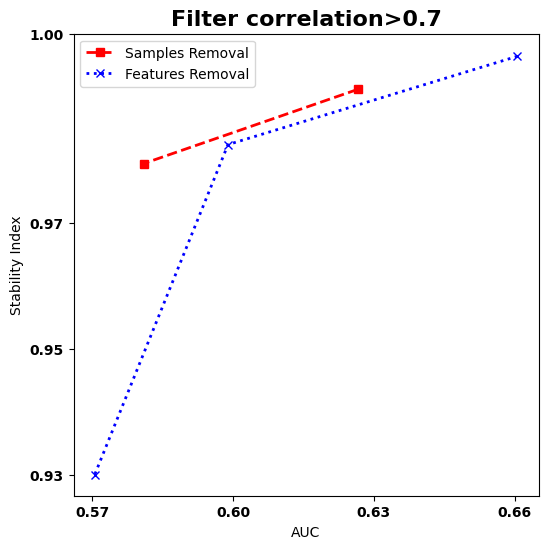

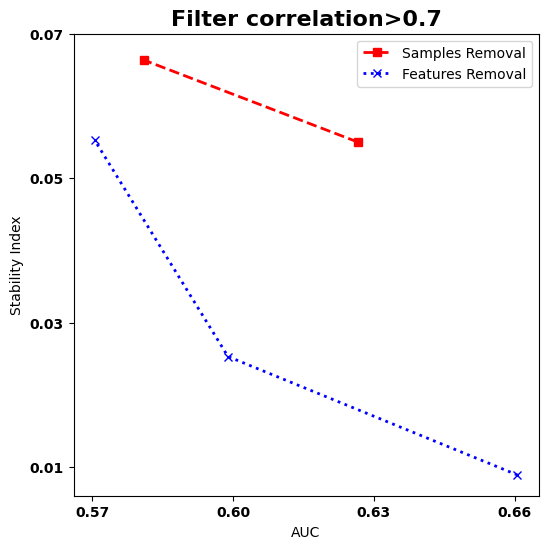

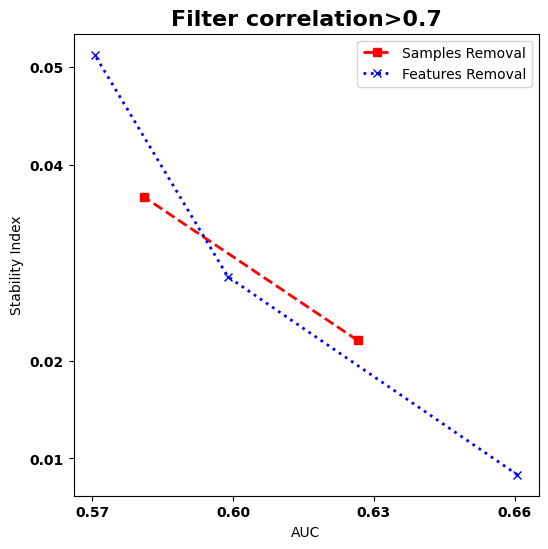

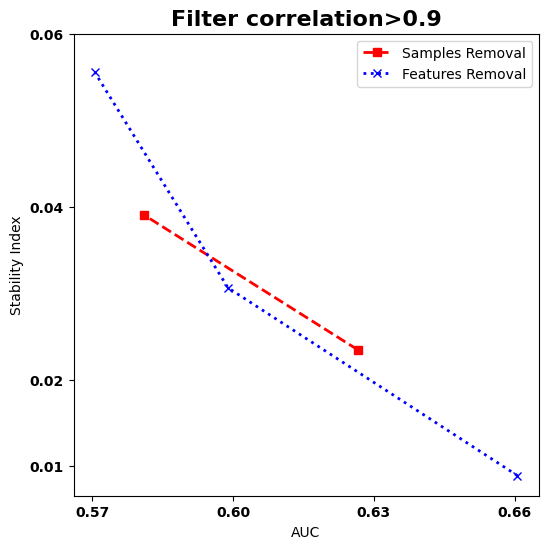

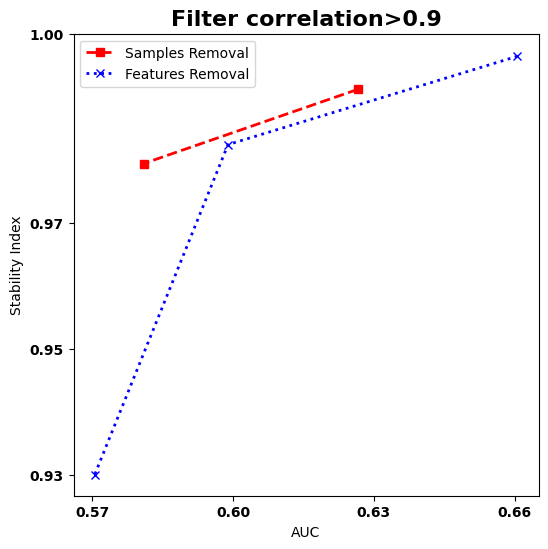

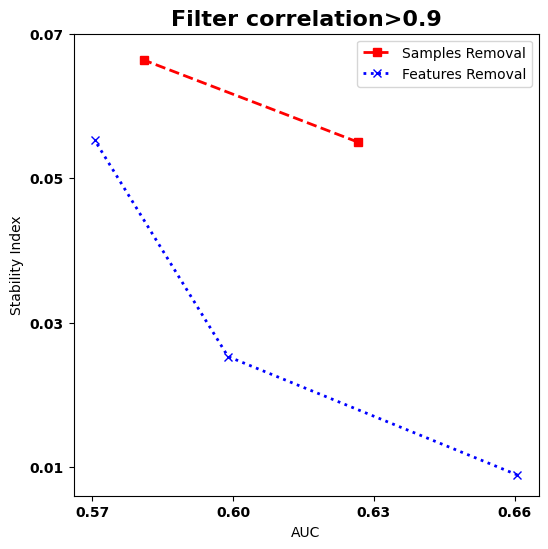

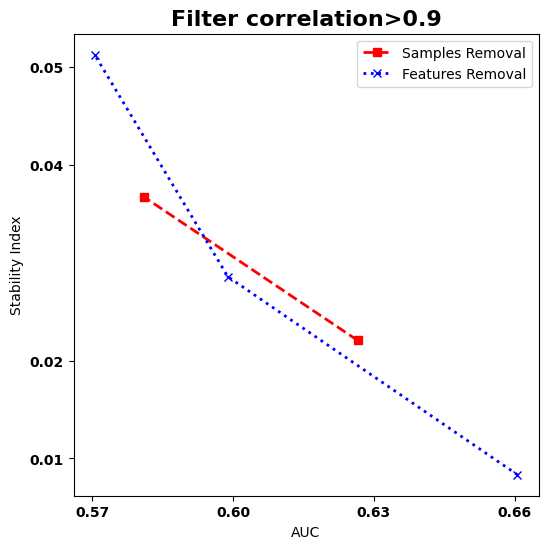

real_3_HT


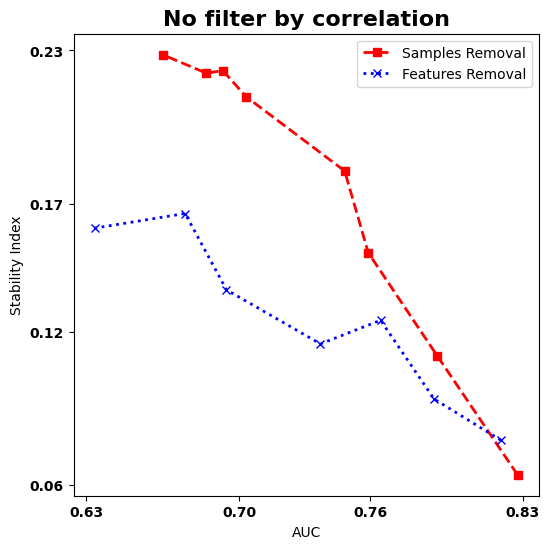

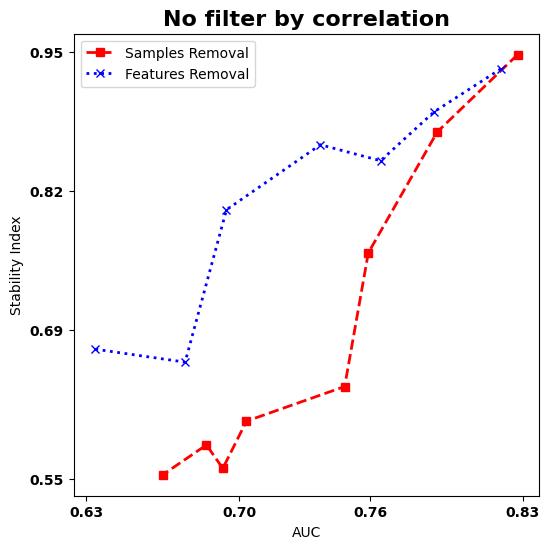

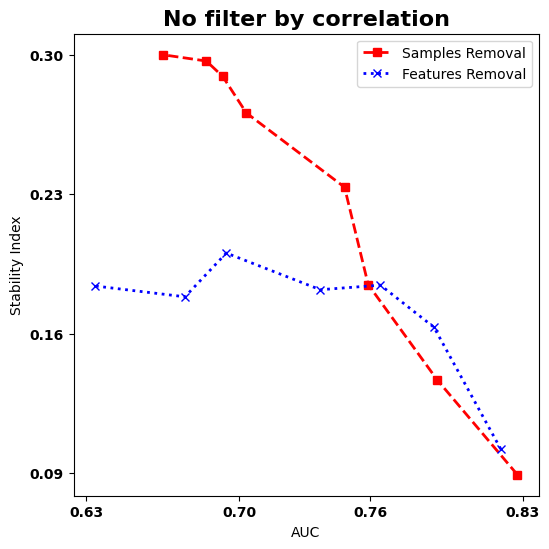

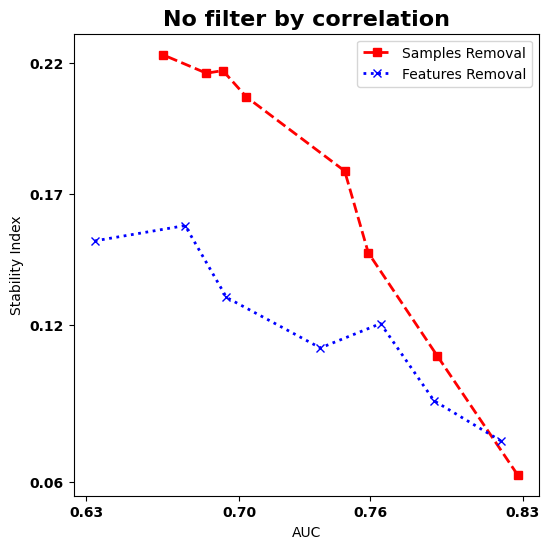

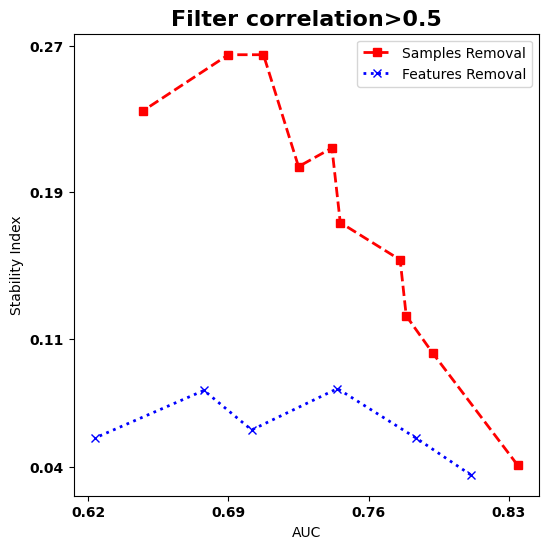

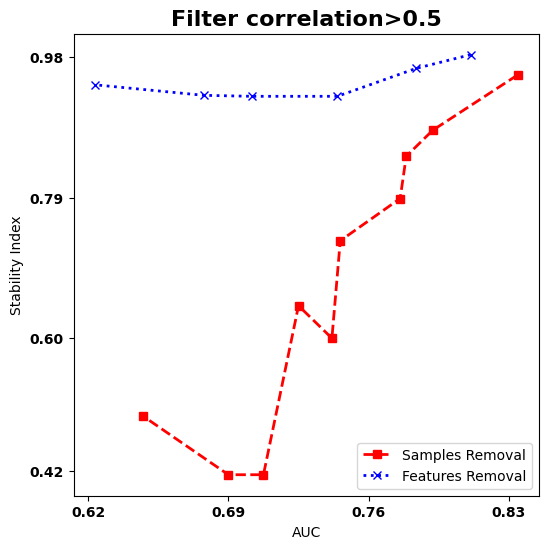

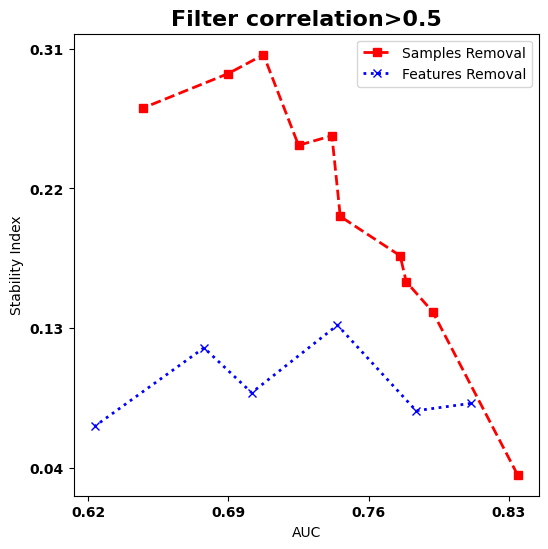

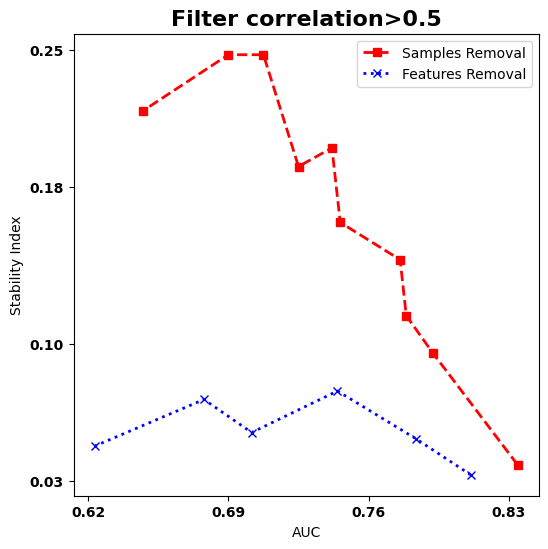

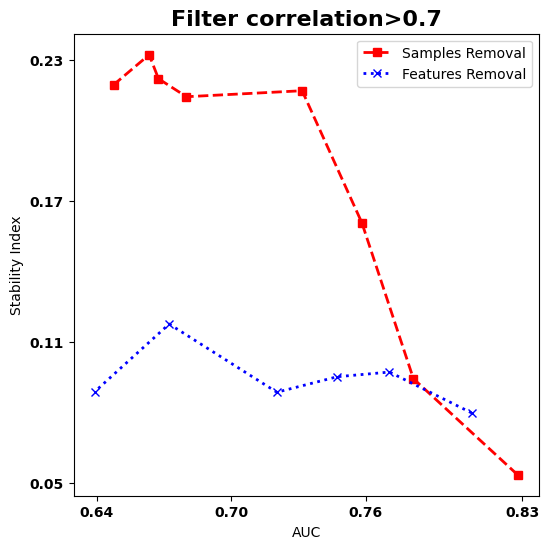

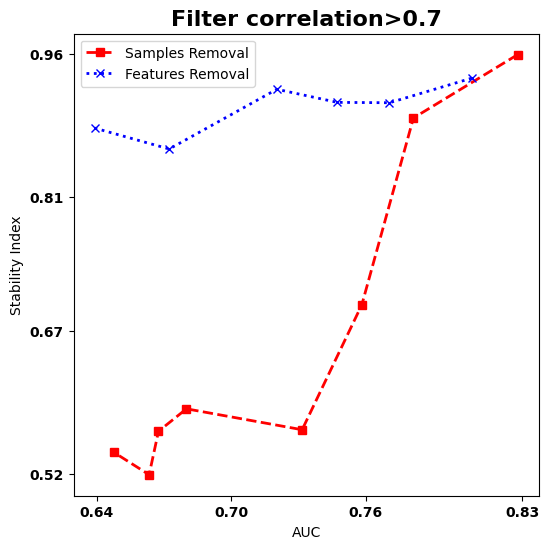

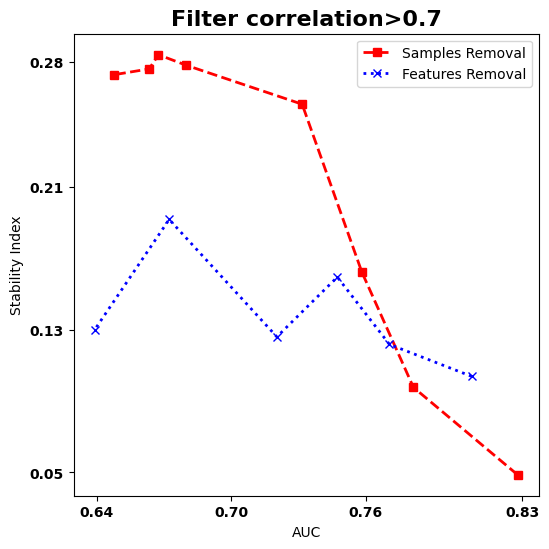

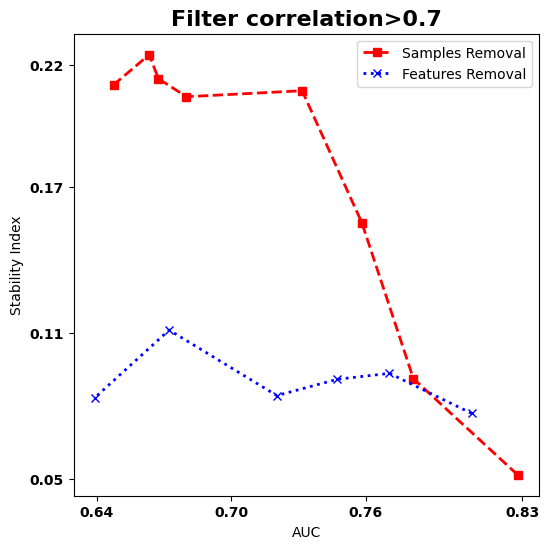

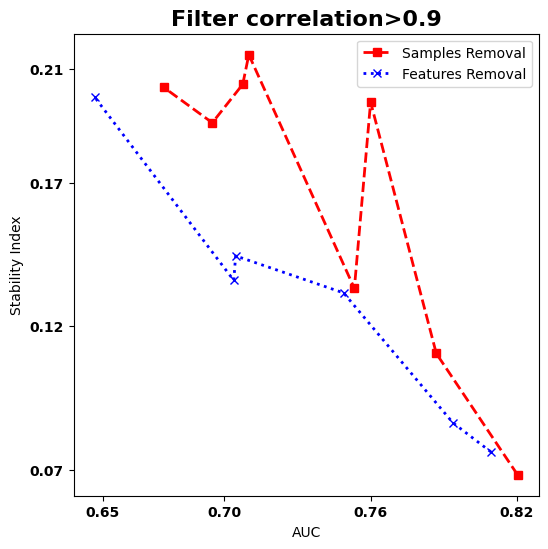

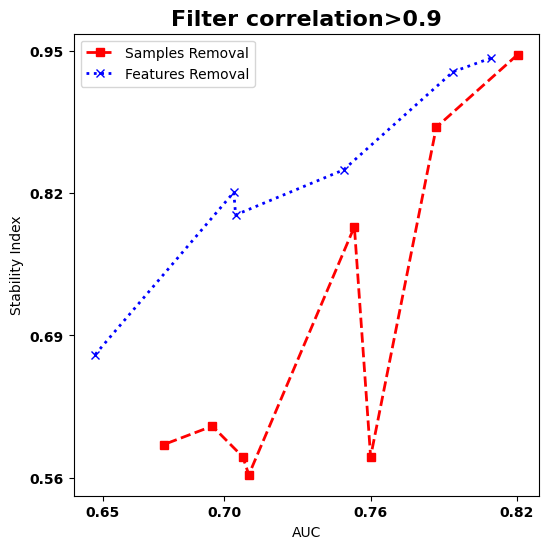

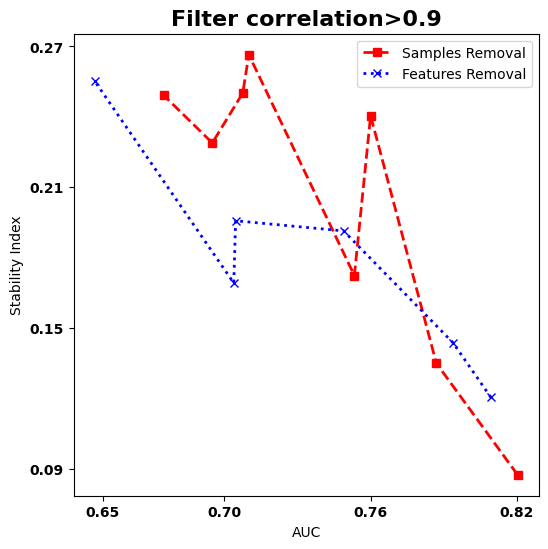

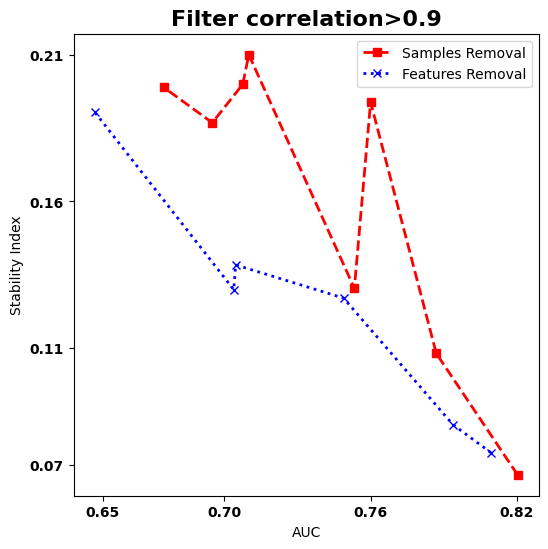

real_4_MS


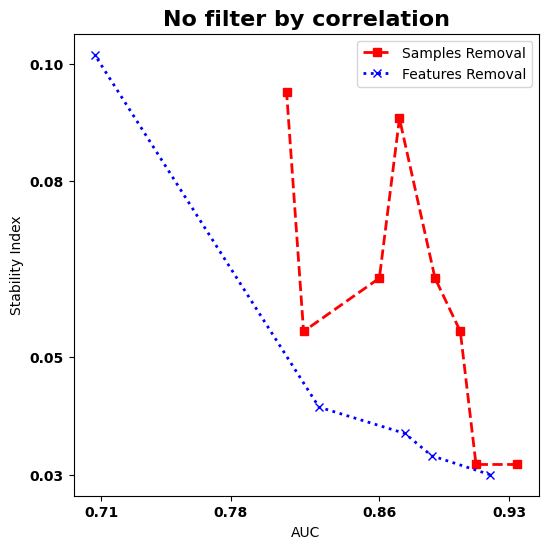

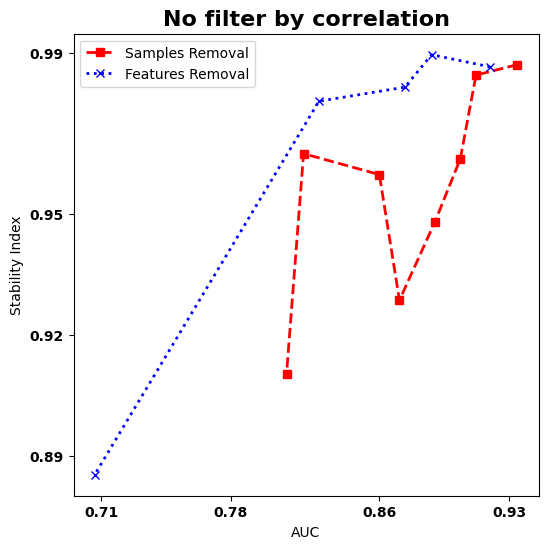

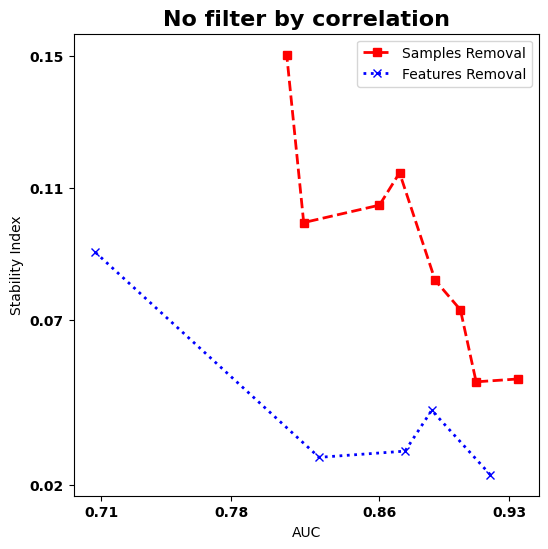

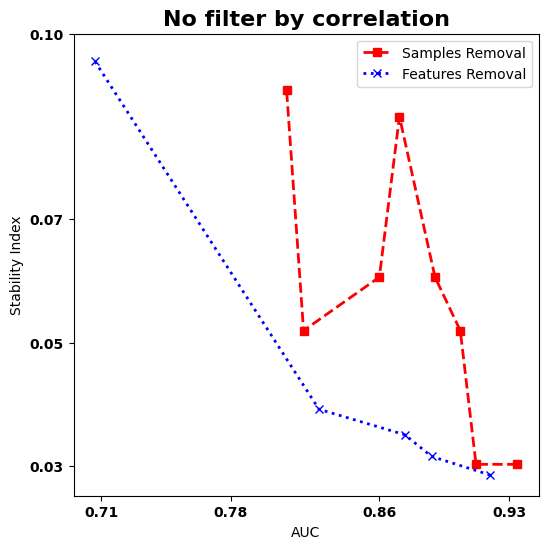

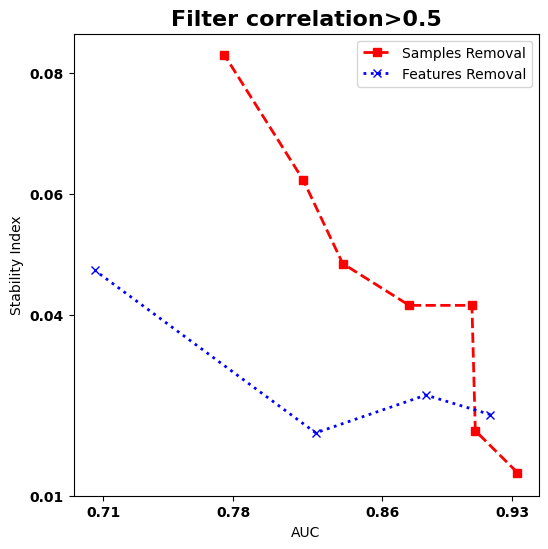

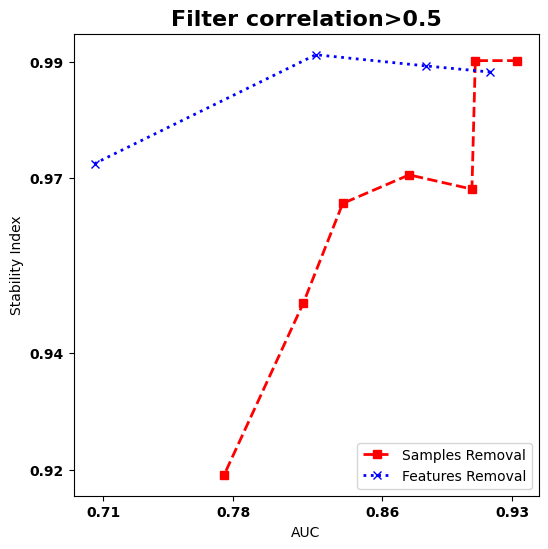

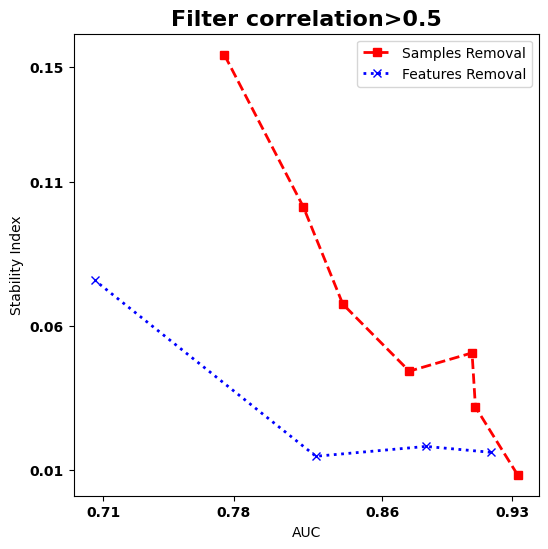

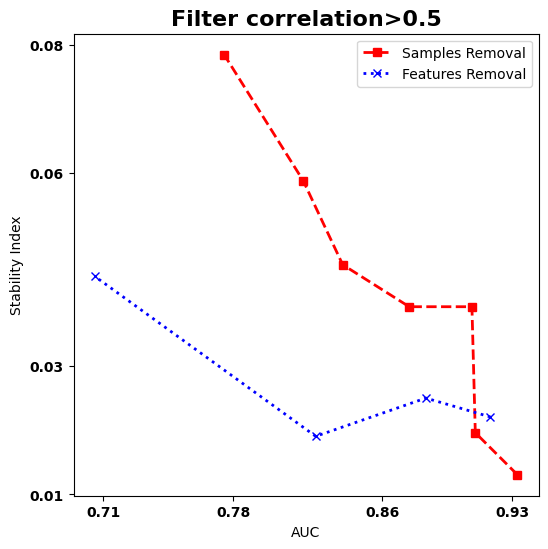

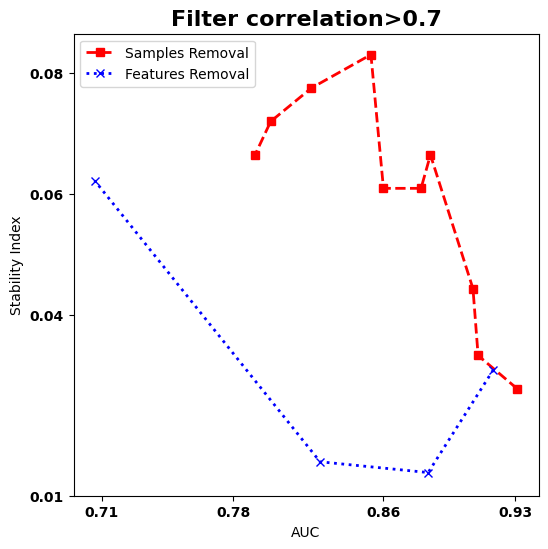

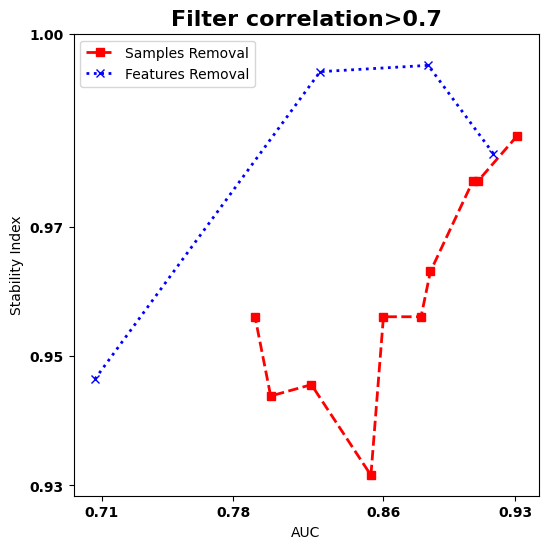

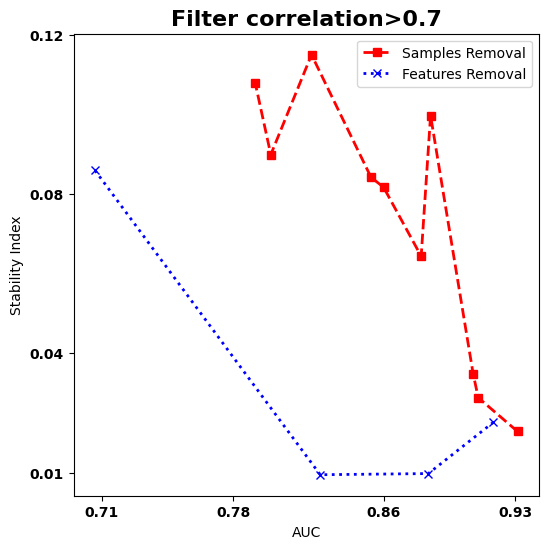

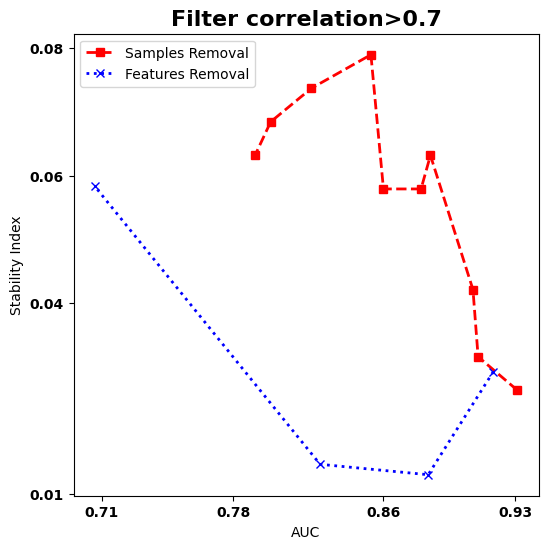

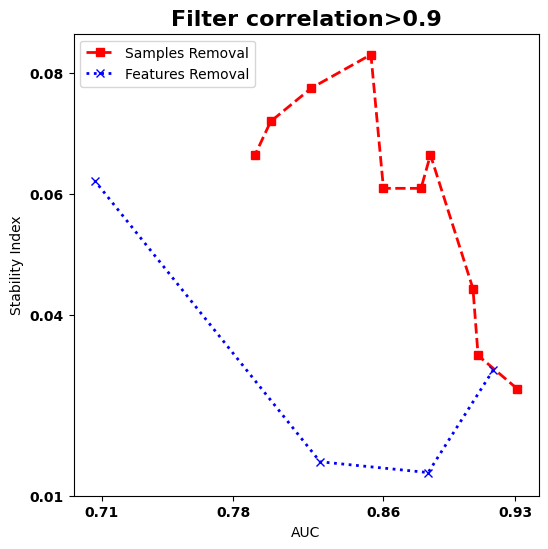

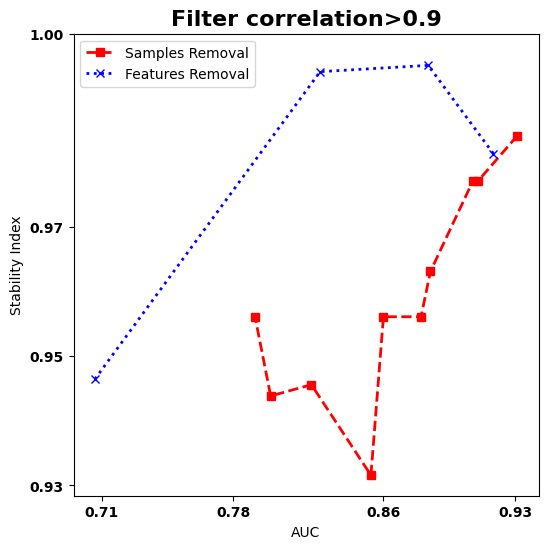

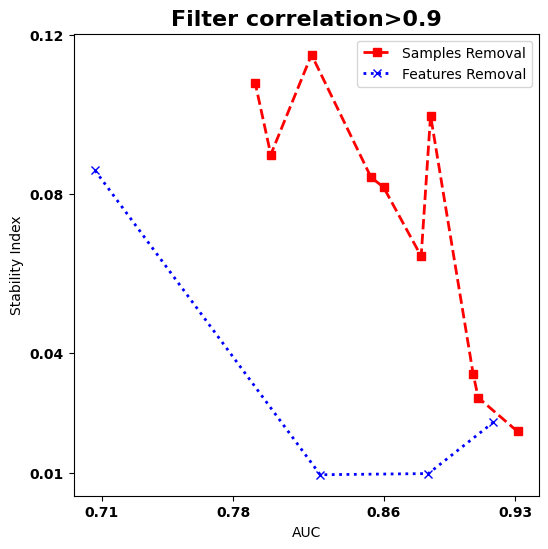

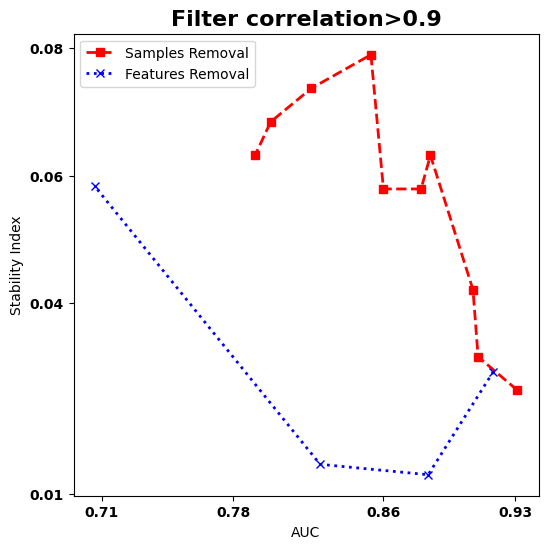

In [45]:
total_stability_data = []
total_stability_feature = []
total_name_list = []


regression_data  = pd.DataFrame()
regression_corr_data  = pd.DataFrame()




cut_algorithm = ["data_cut","feature_cut"]

for loc_folder in list_data:
    if not "generated" in loc_folder and not "real" in loc_folder:
        continue
    print(loc_folder)
    
    
    corr_comparison=np.array([])
    for corr in [0,0.5,0.7,0.9]:
        if not corr==0.0:
            if 'generated' in loc_folder and not 'real' in loc_folder:
                continue
            loc=loc_folder+"/corr_cut/%s"%corr
        else:
            loc=loc_folder
            
        total_name_list.append(loc)
        cut_algorithm = ["data_cut","feature_cut"]
        stability_name_total = ['rank difference','SRCC','CD','Bray-Curtis','weighted_CD_5']


        stability_data  = np.load('../graph/stability/%s/%s.npy'%(loc,cut_algorithm[0]))
        stability_feature = np.load('../graph/stability/%s/%s.npy'%(loc,cut_algorithm[1]))


        stability_data = stability_data[np.logical_not(np.isnan(stability_data[:,1])),:]
        stability_feature = stability_feature[np.logical_not(np.isnan(stability_feature[:,1])),:]


        arrange_arr= stability_data[:,1].argsort()[::-1]
        stability_data = stability_data[arrange_arr,:]


        arrange_arr = stability_feature[:,1].argsort()[::-1]
        stability_feature = stability_feature[arrange_arr,:]


        stability_data= stability_data[1:,:]
        stability_feature= stability_feature[1:,:]

        if not "generated_" in loc:
            
            
            ## cut grid where the AUC is under 0.55
            if np.min(stability_feature[:,1])<0.55:
                left_loc = (stability_feature[:,1]>0.55)
                stability_feature = stability_feature[left_loc,:]

                
        
            if np.min(stability_data[:,1])<0.55:
                left_loc = (stability_data[:,1]>0.55)
                stability_data = stability_data[left_loc,:]

                
            ##cut grid where the AUC is far from the other's minimum
            if np.min(stability_data[:,1])>np.min(stability_feature[:,1]):
                cut_index =  np.argmin(stability_feature[:,1]>np.min(stability_data[:,1]))+1
                stability_feature = stability_feature[:cut_index,:]

            elif np.min(stability_feature[:,1])>np.min(stability_data[:,1]):
                cut_index =  np.argmin(stability_data[:,1]>np.min(stability_feature[:,1]))+1
                stability_data = stability_data[:cut_index,:]
            
            
            ##cut grid where the AUC is far from the other's maximum
            if np.max(stability_data[:,1])>np.max(stability_feature[:,1]):            
                cut_index =  np.argmin(stability_data[:,1]>np.max(stability_feature[:,1]))-1                
                stability_data = stability_data[cut_index:,:]

            elif np.max(stability_feature[:,1])>np.max(stability_data[:,1]):            
                cut_index =  np.argmin(stability_feature[:,1]>np.max(stability_data[:,1]))-1                
                stability_feature = stability_feature[cut_index:,:]
            
         
            

        if not loc in os.listdir(os.getcwd()+"/trimmed_stability/"):
            if not loc in os.listdir(os.getcwd()+"/trimmed_stability/"):
                if "corr" in loc:
                    try:
                        os.mkdir("trimmed_stability/%s"%loc[:-4])
                    except:
                        pass
                try:
                    os.mkdir("trimmed_stability/%s"%loc)
                except:
                    pass
                
                
                
        np.save('trimmed_stability/%s/%s.npy'%(loc,cut_algorithm[0]),stability_data)
        np.save('trimmed_stability/%s/%s.npy'%(loc,cut_algorithm[1]),stability_feature)

        total_stability_data.append(stability_data)
        total_stability_feature.append(stability_feature)
#         cut_algorithm = ["Data Removal","Feature Removal"]
        cut_algorithm = ["Samples Removal","Features Removal"]
        stability_name_total = ['Rank Difference','Spearman%s Rank Correlation Coefficient'%("'s"),'Canberra Distance','Bray-Curtis Dissimilarity']

        reg_result = np.zeros((2,len(stability_name_total)))
        for index,stability_name in enumerate(stability_name_total):

            fig, ax = plt.subplots(figsize=(6,6))
            for cut_index,cut_name in enumerate(cut_algorithm):
                if cut_index == 0 :
                    plt.plot(stability_data[:,1],stability_data[:,2+index], linestyle='--', marker='s', color='r',label = cut_name, linewidth=2) 
        #             lightcoral
                elif cut_index == 1:
                    plt.plot(stability_feature[:,1],stability_feature[:,2+index],linestyle='dotted',marker='x', color='b',label = cut_name, linewidth=2) 
# bx:
            if loc=="generated_1":
                plt.axvline(x=0.8, color='r',alpha=0.5, linestyle='dashed')
            
            
                   
            
            
            
    # , fontsize=12
            plt.xlabel("AUC")
            plt.ylabel("Stability Index")
            plt.legend()
            
            if 'generated' in loc_folder and not 'real' in loc_folder:
                plt.title(stability_name)
                plt.savefig('trimmed_stability/%s/%s.jpg'%(loc,stability_name), dpi=600, bbox_inches='tight')
                plt.show()            
            
            else:
                if corr==0.5:
                    plt.title("Real Dataset #%s"%loc_folder[5], fontsize=16)
                    plt.savefig('trimmed_stability/%s/real_%s.jpg'%(loc,stability_name), dpi=600, bbox_inches='tight')
#                     plt.show()
                             
                name_corr = ""
                if corr==0.0:
                    name_corr = "No filter by correlation"
                elif corr==0.5:
                    name_corr = "Filter correlation>0.5"
                elif corr==0.7:
                    name_corr = "Filter correlation>0.7"
                elif corr==0.9:
                    name_corr = "Filter correlation>0.9"
                    
                    
                    
#                 x_ticks = np.round(np.linspace(total_range_min[int(loc_folder[5])-1,index,0],total_range_max[int(loc_folder[5])-1,index,0], 4), 2) 
#                 y_ticks = np.round(np.linspace(total_range_min[int(loc_folder[5])-1,index,1],total_range_max[int(loc_folder[5])-1,index,1], 4), 2) 
                
        
                auc_array = np.concatenate((stability_data[:,1],stability_feature[:,1]))
                x_ticks = np.round(np.linspace(np.min(auc_array),np.max(auc_array), 4), 2)
                
                stab_array = np.concatenate((stability_data[:,2+index],stability_feature[:,2+index]))
                
                y_ticks = np.round(np.linspace(np.min(stab_array),np.max(stab_array), 4), 2) 
    
    
                plt.xticks(ticks=x_ticks, fontweight="bold")
                plt.yticks(ticks=y_ticks, fontweight="bold")

            
                
                plt.title(name_corr, fontsize=16, fontweight="bold") 
                plt.savefig('trimmed_stability/%s/%s.jpg'%(loc,stability_name), dpi=600, bbox_inches='tight')
                plt.show()

            
            
            
            
            
            
            
            
            
    
            auc_grid = np.append(stability_data[:,1],stability_feature[:,1])
            factor_grid = np.append(np.zeros((stability_data[:,1].shape[0],)),np.ones((stability_feature[:,1].shape[0],)))
            features = np.append(auc_grid.reshape(-1,1),factor_grid.reshape(-1,1),axis=1)
            features =pd.DataFrame(features,columns=['AUC','Feature cut'])
            stability_grid = np.append(stability_data[:,2+index],stability_feature[:,2+index])


            if stability_feature[:,1].shape[0]==0 or stability_data[:,1].shape[0]==0:
                continue
            X2 = sm.add_constant(features)
            est = sm.OLS(stability_grid, X2)
            est2 = est.fit()
            reg_result[0,index] =np.round(est2.params[2],3)
            reg_result[1,index] =np.round(est2.pvalues[2],3)          
      
#             print(est2.summary())
#             print(est2.params[2])
#             print(est2.pvalues[2])

        if stability_feature[:,1].shape[0]==0 or stability_data[:,1].shape[0]==0:
            continue
            
        if not corr==0:
            if corr_comparison.shape[0]==0:
                corr_comparison = np.append(np.array([corr]).reshape(-1,1),reg_result[0,:].reshape(1,-1),axis=1)
                corr_comparison = corr_comparison.reshape(-1,5)

            else:
                corr_comparison = np.append(corr_comparison,np.append(np.array([corr]).reshape(-1,1),reg_result[0,:].reshape(1,-1),axis=1),axis=0)
                corr_comparison = corr_comparison.reshape(-1,5)

        
        regression_data = regression_data.append({'Name':loc,
                                                  '# of data cut':stability_data.shape[0],
                                                  '# of feature cut':stability_feature.shape[0],                                                  
                                                  'rank difference (coeff)':reg_result[0,0],
                                                  'SRCC (coeff)':reg_result[0,1],
                                                  'CD (coeff)':reg_result[0,2],
                                                  'Bray-Curtis (coeff)':reg_result[0,3],
                                                  'rank difference(p-value)':reg_result[1,0],'SRCC(p-value)':reg_result[1,1],
                                                  'CD(p-value)':reg_result[1,2],'Bray-Curtis(p-value)':reg_result[1,3]                                        
                                                },                                                
                                                 ignore_index=True)
        
    if 'generated' in loc_folder and not 'real' in loc_folder:
        continue
    corr_coeff = np.array([])
    corr_pvalue = np.array([])
    for index,stability_name in enumerate(stability_name_total):

        X2 = sm.add_constant(corr_comparison[:,0])
        est = sm.OLS(corr_comparison[:,1+index], X2)
        est2 = est.fit()
        corr_coeff = np.append(corr_coeff,np.round(est2.params[1],3))            
        corr_pvalue = np.append(corr_pvalue,np.round(est2.pvalues[1],3))

    regression_corr_data = regression_corr_data.append({'Name':loc_folder,
                                                  '# of data cut':stability_data.shape[0],
                                                  '# of feature cut':stability_feature.shape[0],                                                              
                                              'rank difference (coeff)':corr_coeff[0],
                                              'SRCC (coeff)':corr_coeff[1],
                                              'CD (coeff)':corr_coeff[2],
                                              'Bray-Curtis (coeff)':corr_coeff[3],
                                              'rank difference(p-value)':corr_pvalue[0],'SRCC(p-value)':corr_pvalue[1],
                                              'CD(p-value)':corr_pvalue[2],'Bray-Curtis(p-value)':corr_pvalue[3]                                        
                                            },                                                
                                             ignore_index=True)
         
    
regression_data.to_csv("trimmed_regression_data.csv")

regression_corr_data.to_csv("trimmed_regression_corr_data.csv")

        # calculating the p-value


# Comparing between generated datasets

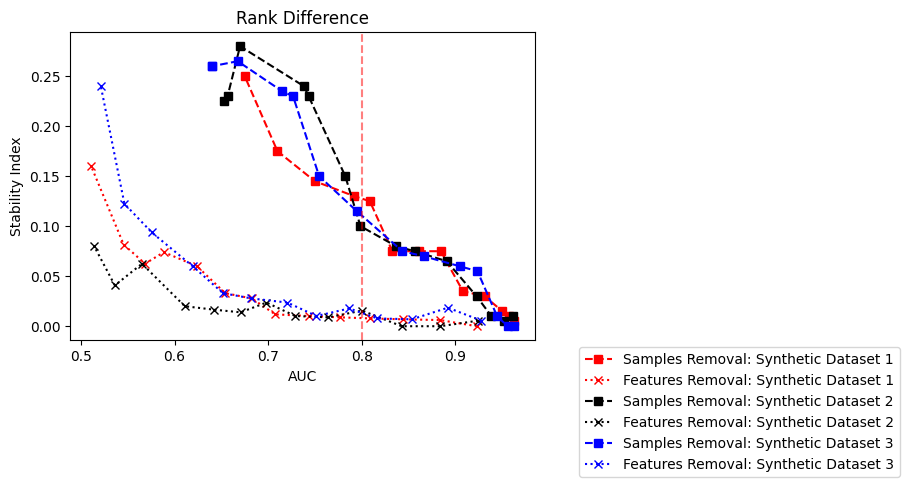

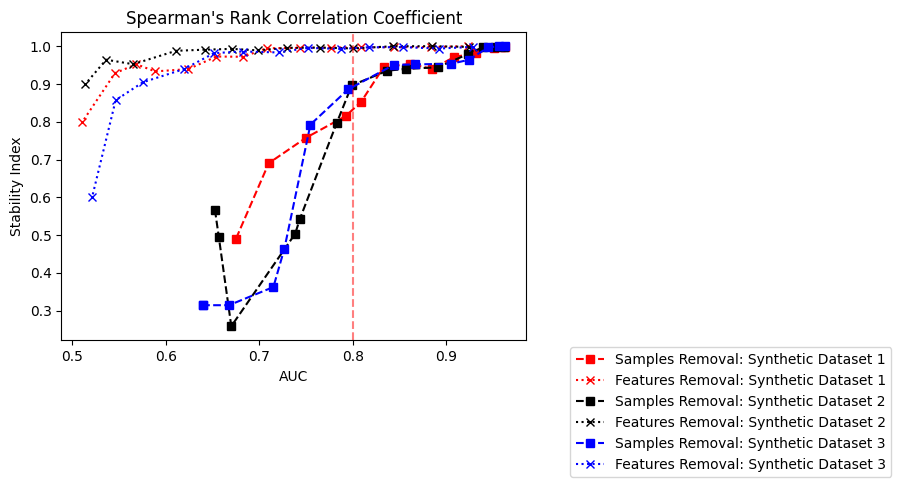

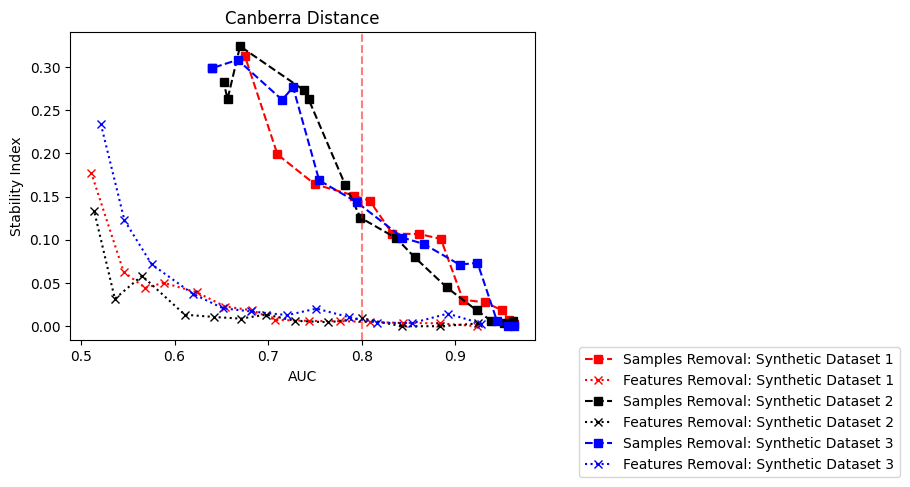

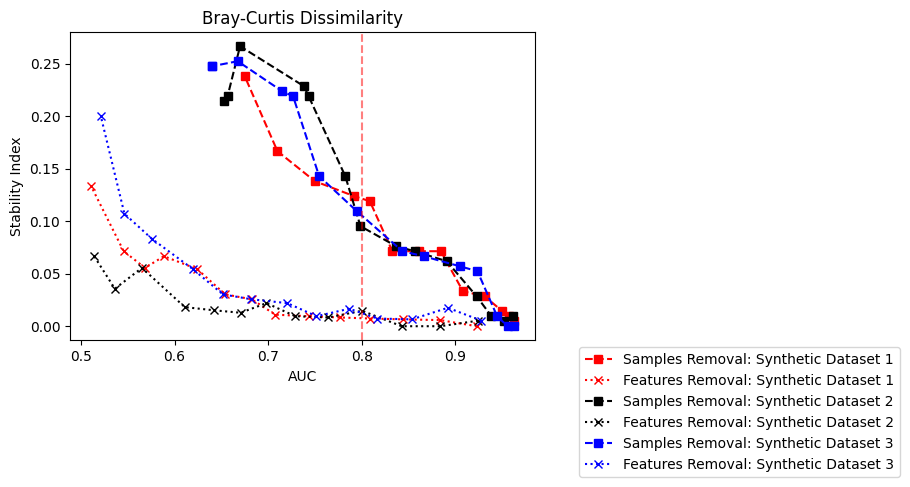

In [44]:


cut_algorithm = ["data_cut","feature_cut"]
# color_list = ['lightcoral','gold','slateblue']
color_list = ['r','black','b']
    
stability_name_total = ['Rank Difference','Spearman%s Rank Correlation Coefficient'%("'s"),'Canberra Distance','Bray-Curtis Dissimilarity']
data_name = ["Synthetic Dataset 1","Synthetic Dataset 2","Synthetic Dataset 3"]

for index,stability_name in enumerate(stability_name_total):
    
    fig, ax = plt.subplots(figsize=(6,4))
    for loc_index,loc_folder in enumerate(['generated_1', 'generated_2', 'generated_3']):
        cut_algorithm = ["data_cut","feature_cut"]


        stability_data  = np.load('../graph/stability/%s/%s.npy'%(loc_folder,cut_algorithm[0]))
        stability_feature = np.load('../graph/stability/%s/%s.npy'%(loc_folder,cut_algorithm[1]))


        grid_data = np.load("../result/"+loc_folder+"/"+cut_algorithm[0]+"/grid.npy")

        grid_feature = np.load("../result/"+loc_folder+"/"+cut_algorithm[1]+"/grid.npy")



        grid_data = grid_data[np.logical_not(np.isnan(grid_data[:,1])),:]
        stability_data = stability_data[np.logical_not(np.isnan(stability_data[:,1])),:]
        grid_feature = grid_feature[np.logical_not(np.isnan(grid_feature[:,1])),:]
        stability_feature = stability_feature[np.logical_not(np.isnan(stability_feature[:,1])),:]


        arrange_arr= grid_data[:,1].argsort()[::-1]
        grid_data = grid_data[arrange_arr,:]
        stability_data = stability_data[arrange_arr,:]


        arrange_arr = grid_feature[:,1].argsort()[::-1]
        grid_feature = grid_feature[arrange_arr,:]
        stability_feature = stability_feature[arrange_arr,:]


        cut_algorithm = ["Samples Removal","Features Removal"]


        for cut_index,cut_name in enumerate(cut_algorithm):
            if cut_index == 0 :
                plt.plot(stability_data[1:,1],stability_data[1:,2+index], linestyle='--', marker='s', color=color_list[loc_index],label = "%s: %s"%(cut_name,data_name[loc_index]))
    #             plt.plot(stability_data[:,1],stability_data[:,2+index],'cs--',label = cut_name)
            elif cut_index == 1:
                plt.plot(stability_feature[1:,1],stability_feature[1:,2+index],'bx:', color=color_list[loc_index],label = "%s: %s"%(cut_name,data_name[loc_index]))
     
                
                
                
    plt.axvline(x=0.8, color='r',alpha=0.5, linestyle='dashed')
    plt.title(stability_name)
# , fontsize=12
    plt.xlabel("AUC")
    plt.ylabel("Stability Index")
    plt.legend(bbox_to_anchor=(1.8, 0))


    plt.savefig('Figures/generated_comparison/Generated_%s.jpg'%(stability_name), dpi=600, bbox_inches='tight')
    plt.show()





# Dataset Correlation comparison

In [248]:
total_corr_name = ["Max Correlation = 0.3","Max Correlation = 0.5","Max Correlation = 0.7","Max Correlation = 0.9"]
line_style =['-','--','dotted','-.']
color_style = ['#377eb8', '#ff7f00', '#4daf4a',
                  '#a65628']
stability_name = ['Rank Difference','Spearman%s Rank Correlation Coefficient'%("'s"),'Canberra Distance','Bray-Curtis Dissimilarity']



In [257]:
cut_algorithm

['data_cut', 'feature_cut']

real_1_IBD


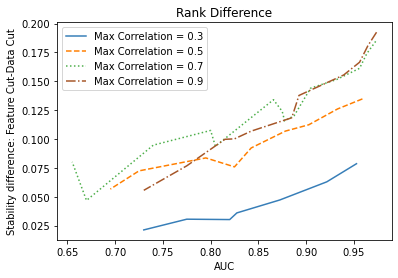

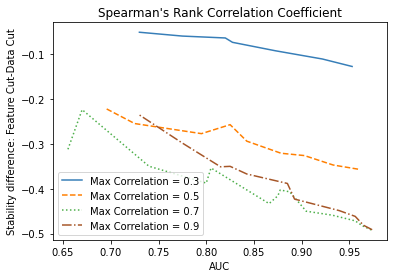

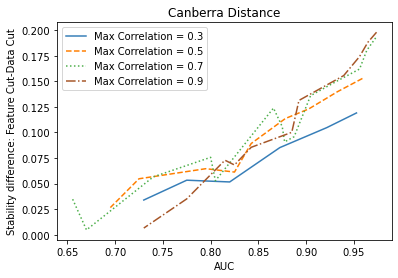

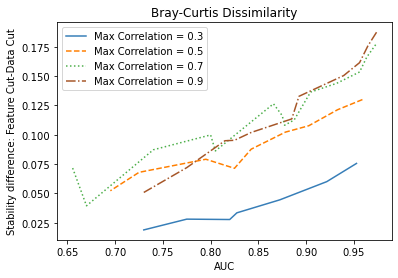

real_2_DR


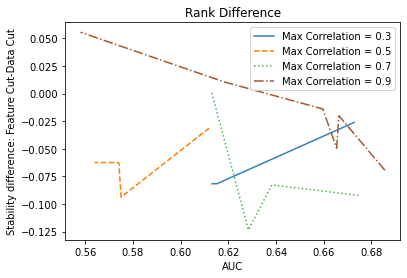

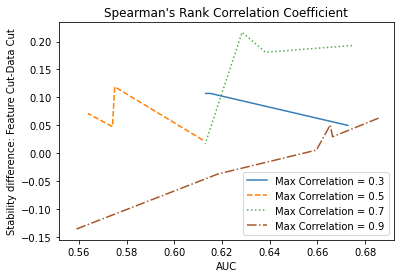

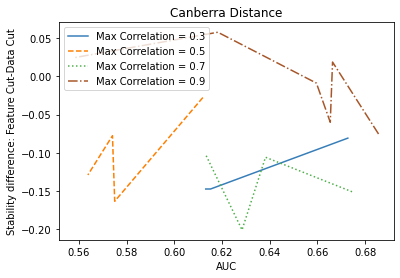

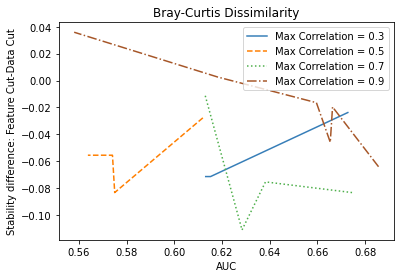

real_3_HF


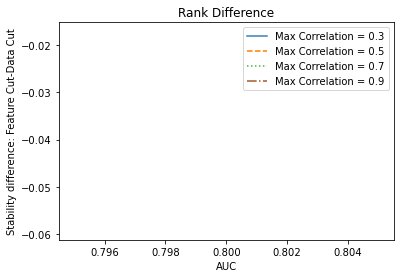

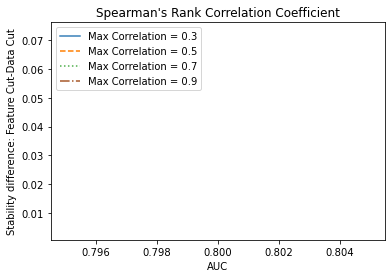

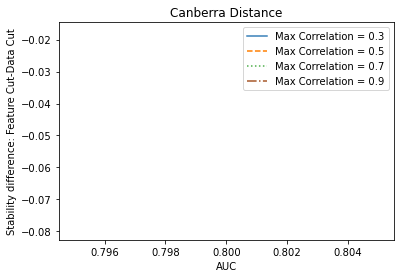

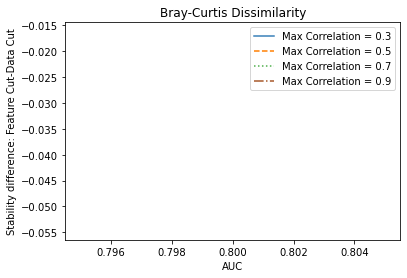

real_4_TS


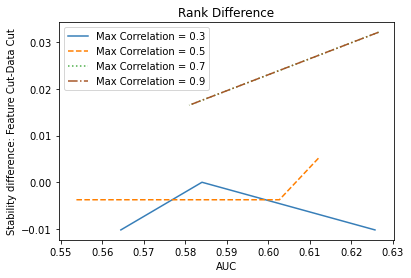

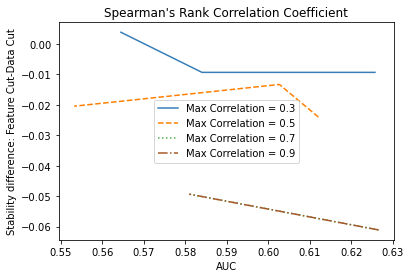

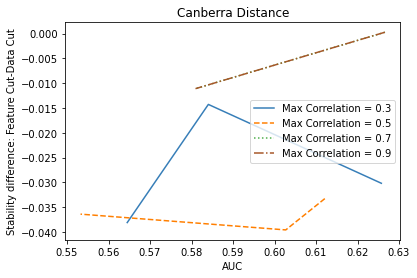

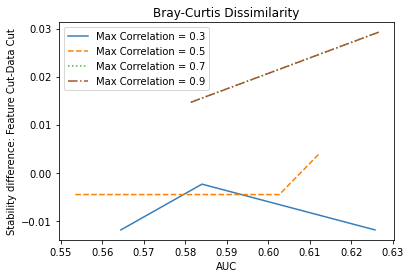

real_5_HT


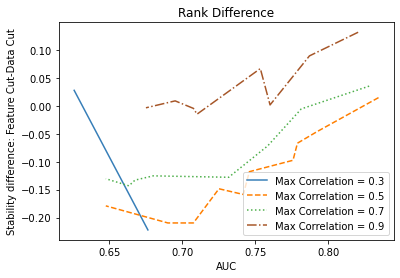

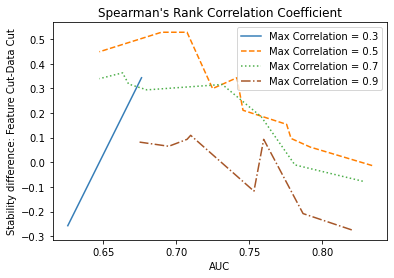

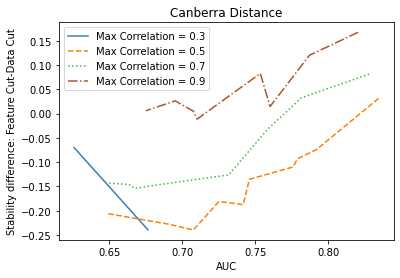

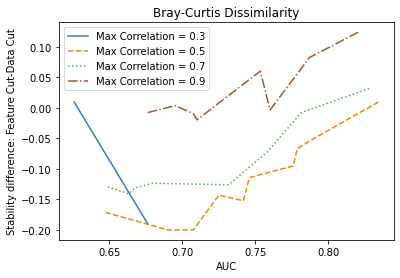

real_6_BC


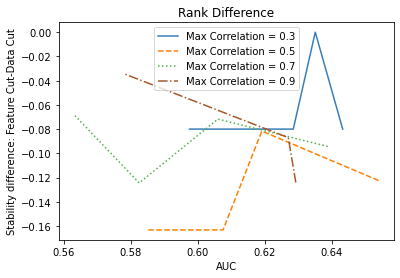

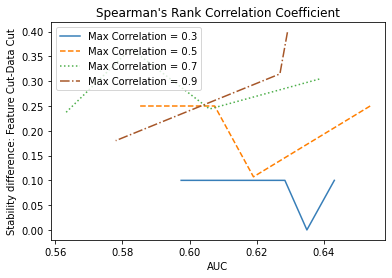

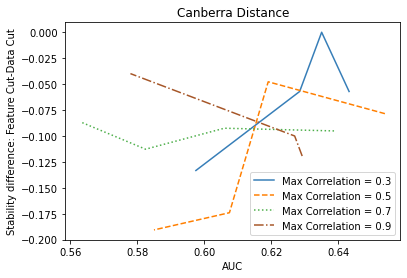

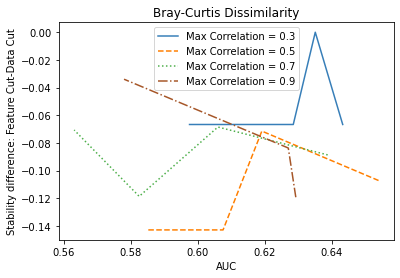

In [262]:


for loc_index,loc_folder in enumerate(list_data):
    if not "generated" in loc_folder and not "real" in loc_folder:
        continue
    if "generated" in loc_folder:
        continue
    print(loc_folder)
    
    loc =loc_folder
    
    try:
        os.mkdir("correlation_trend/%s"%loc)
    except:
        pass
    
    
    corr_list = np.array(total_corr_name)
    for index,score_name in enumerate(stability_name):

        fig, ax = plt.subplots(figsize=(6,4))

        for corr_index,corr_name in enumerate(total_corr_name):

            
            
            loc=loc_folder+"/corr_cut/%s"%(np.round(0.3+0.2*corr_index,1))

            

            stability_data=np.load('trimmed_stability/%s/%s.npy'%(loc,cut_algorithm[0]))
            stability_feature = np.load('trimmed_stability/%s/%s.npy'%(loc,cut_algorithm[1]))


            
            if stability_data[:,1].shape[0]==0:
                corr_list = np.delete(corr_list,corr_index)
                continue
            if np.min(stability_data[:,1]) > np.min(stability_feature[:,1]):
                plt.plot(stability_data[:,1],np.interp(stability_data[:,1],stability_feature[:,1],stability_feature[:,2+index])-stability_data[:,2+index], linestyle=line_style[corr_index],color= color_style[corr_index],label=corr_name)

            else:
                plt.plot(stability_feature[:,1],stability_feature[:,2+index]-np.interp(stability_feature[:,1],stability_data[:,1],stability_data[:,2+index]), linestyle=line_style[corr_index],color= color_style[corr_index],label=corr_name)



        plt.xlabel("AUC")
        plt.ylabel("Stability difference: Feature Cut-Data Cut")



        plt.title(score_name)
        plt.legend()
        plt.savefig('correlation_trend/%s/%s.jpg'%(loc_folder,score_name), dpi=600, bbox_inches='tight')
        plt.show()

